# Исследование объявлений о продаже квартир


<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Вызов-библиотек" data-toc-modified-id="Вызов-библиотек-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Вызов библиотек</a></span></li><li><span><a href="#Блок-функций" data-toc-modified-id="Блок-функций-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Блок функций</a></span></li><li><span><a href="#Изучение-данных-из-файла" data-toc-modified-id="Изучение-данных-из-файла-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Изучение данных из файла</a></span><ul class="toc-item"><li><span><a href="#Описание-данных" data-toc-modified-id="Описание-данных-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Описание данных</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Предобработка данных</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Расчёты-и-добавление-результатов-в-таблицу" data-toc-modified-id="Расчёты-и-добавление-результатов-в-таблицу-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Расчёты и добавление результатов в таблицу</a></span></li><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Общий вывод</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

## Вызов библиотек

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import seaborn as sns
import re
import warnings

from collections import Counter
from nltk.stem.snowball import SnowballStemmer 

warnings.filterwarnings('ignore')

## Блок функций

In [2]:
# функция заполнения пропущенных значений

def fills_good(data, main_column, function, group_columns):
    """Функция заполнения пропущенных значений

    Для использования функции необходимо передать ей
    следующие аргументы:
    
    data - массив данных, в котором необходимо заполнить пропуски;
    main_column - столбец в котором пропущены значения;
    function - значение функции, которая будет применяться при
         заполнении пустых значений в кавычках ('mean','median'...);
    group_columns - столбцы для группировки данных в виде массива [...] 
         заполнение пропусков будет производиться в соответствии
         с группировкой по указанным столбцам.
    """
    
    data[main_column] = data[main_column].fillna(data.groupby(group_columns)[main_column].transform(function))

    

    
def pre_research(data, column, bins_count, range_min=99, range_max=99):
    """Функция предварительного анализа данных
    Данная функция выведет уникальные значения указанного
    столбца и построит гистограмму.

    Для использования функции необходимо передать ей
    следующие аргументы:
    
    data - массив данных, которые нужно анализировать;
    column - название столбца, по которому проводится анализ;
    bins_count - количество корзин в гистограмме;
    range_min, range_max - минимальное и максимальное
        граничные значения, выводимые на гистограмму
        по умолчанию задаются минимумом и максимумом значений столбца, 
        при необходимости можно внести нужные занчения для 
        масштабирования гистограммы.
    """
    
    print(f'Уникальные значения {column}: \n', data[column].sort_values().unique())
    print(f'1-й персентиль {data[column].quantile(.1)}')
    print(f'99-й персентиль {data[column].quantile(.99)}')
    # В столбце есть выбросы значений, построим гистограмму для того, 
    # чтобы понять как часто встречаются большие и очень малые значения
    if range_min==range_max:
        range_min = data[column].min()
        range_max = data[column].max()
    data[column].hist(bins=bins_count,range=(range_min,range_max))


def print_hist(series,bins, title):
    """Функция построения гистограммы

    Для использования функции необходимо передать ей
    следующие аргументы:
    
    series - столбец данных для построения гистограммы;
    bins - количесттво корзин;
    title - название графика.
    
        Для улучшения визуализации распределения данных
    минимальное и максимальное значения для построения
    считаются по 1 и 99му персентилю
    """   
    
    fig = plt.figure(figsize=(15, 6)) 
    min_range = series.quantile(.1)
    max_range = series.quantile(.99)
    hist = plt.hist(series, bins, range = (min_range,max_range))
    grid1 = plt.grid(True)
    plt.title(title)
    plt.show()
    print(f'Среднее значение: {round(series.mean(),2)}')
    print(f'Медианное значение: {round(series.median(),2)}')
    

def print_matrix(data, sub_columns, min_size=9, max_size=9):
    """Функция построения матрицы диаграмм рассеяния

    Для использования функции необходимо передать ей
    следующие аргументы:
    
    data - массив исходных данных;
    main_column - основной столбец данных, относительно которого будет
        проводиться анализ - 'название_столбца';
    sub_columns - вспомогательные столбцы, влияние которых на
        основной столбец мы оцениваем - ['1','2','3',...];
    min_size, max_size - минимальное и максимальное значение размера
        каждой ячейки матрицы в дюймах (по умолчанию - 9 дюймов).
    """
    
    #pivot_data = data.pivot_table(index = main_column, 
    #                        values = sub_columns)
    pivot_data = data[sub_columns]
    pd.plotting.scatter_matrix(pivot_data, diagonal = 'kde',figsize=(min_size, max_size)) 

def print_scatter(data, x, y, labels, clr = "g", min_size=15, max_size=8):
    """Функция построения диаграмм рассеяния

    Для использования функции необходимо передать ей
    следующие аргументы:
    
    data - массив исходных данных;
    x, y - названия столбцов, относительно которых будет
        проводиться анализ - 'название_столбца';
    labels - массив названий диаграммы и осей - ['Заголовок','x_name','y_name'];
    clr - цвет точек;
    min_size, max_size - минимальное и максимальное значение размера
        каждой ячейки матрицы в дюймах (по умолчанию - 9 дюймов).
    """
    
    plt.figure(figsize=(min_size, max_size)) 
    plt.scatter( x, y, data=data,alpha=0.2,color=clr)
    plt.title(labels[0],fontsize=15)
    plt.xlabel(labels[1],fontsize=13)
    plt.ylabel(labels[2],fontsize=13)
    plt.grid()
    plt.show()

## Изучение данных из файла

### Описание данных
* airports_nearest — расстояние до ближайшего аэропорта в метрах (м)
* balcony — число балконов
* ceiling_height — высота потолков (м)
* cityCenters_nearest — расстояние до центра города (м)
* days_exposition — сколько дней было размещено объявление (от публикации до снятия)
* first_day_exposition — дата публикации
* floor — этаж
* floors_total — всего этажей в доме
* is_apartment — апартаменты (булев тип)
* kitchen_area — площадь кухни в квадратных метрах (м²)
* last_price — цена на момент снятия с публикации
* living_area — жилая площадь в квадратных метрах(м²)
* locality_name — название населённого пункта
* open_plan — свободная планировка (булев тип)
* parks_around3000 — число парков в радиусе 3 км
* parks_nearest — расстояние до ближайшего парка (м)
* ponds_around3000 — число водоёмов в радиусе 3 км
* ponds_nearest — расстояние до ближайшего водоёма (м)
* rooms — число комнат
* studio — квартира-студия (булев тип)
* total_area — площадь квартиры в квадратных метрах (м²)
* total_images — число фотографий квартиры в объявлении

Пояснение: апартаменты — это нежилые помещения, не относящиеся к жилому фонду, но имеющие необходимые условия для проживания.

In [3]:
df = pd.read_csv('real_estate_data.csv', sep='\t')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [5]:
df.describe()

total_images    last_price    total_area         rooms  ceiling_height  \
count  23699.000000  2.369900e+04  23699.000000  23699.000000    14504.000000   
mean       9.858475  6.541549e+06     60.348651      2.070636        2.771499   
std        5.682529  1.088701e+07     35.654083      1.078405        1.261056   
min        0.000000  1.219000e+04     12.000000      0.000000        1.000000   
25%        6.000000  3.400000e+06     40.000000      1.000000        2.520000   
50%        9.000000  4.650000e+06     52.000000      2.000000        2.650000   
75%       14.000000  6.800000e+06     69.900000      3.000000        2.800000   
max       50.000000  7.630000e+08    900.000000     19.000000      100.000000   

       floors_total   living_area         floor  kitchen_area       balcony  \
count  23613.000000  21796.000000  23699.000000  21421.000000  12180.000000   
mean      10.673824     34.457852      5.892358     10.569807      1.150082   
std        6.597173     22.030445      4.885249      5.905438      1.071300   
min        1.000000      2.000000      1.000000      1.300000      0.000000   
25%        5.000000     18.600000      2.000000      7.000000      0.000000   
50%        9.000000     30.000000      4.000000      9.100000      1.000000   
75%       16.000000     42.300000      8.000000     12.000000      2.000000   
max       60.000000    409.700000     33.000000    112.000000      5.000000   

       airports_nearest  cityCenters_nearest  parks_around3000  parks_nearest  \
count      18157.000000         18180.000000      18181.000000    8079.000000   
mean       28793.672193         14191.277833          0.611408     490.804555   
std        12630.880622          8608.386210          0.802074     342.317995   
min            0.000000           181.000000          0.000000       1.000000   
25%        18585.000000          9238.000000          0.000000     288.000000   
50%        26726.000000         13098.500000          0.000000     455.000000   
75%        37273.000000         16293.000000          1.000000     612.000000   
max        84869.000000         65968.000000          3.000000    3190.000000   

       ponds_around3000  ponds_nearest  days_exposition  
count      18181.000000    9110.000000     20518.000000  
mean           0.770255     517.980900       180.888634  
std            0.938346     277.720643       219.727988  
min            0.000000      13.000000         1.000000  
25%            0.000000     294.000000        45.000000  
50%            1.000000     502.000000        95.000000  
75%            1.000000     729.000000       232.000000  
max            3.000000    1344.000000      1580.000000

In [6]:
df.head(10)

total_images  last_price  total_area first_day_exposition  rooms  \
0            20  13000000.0      108.00  2019-03-07T00:00:00      3   
1             7   3350000.0       40.40  2018-12-04T00:00:00      1   
2            10   5196000.0       56.00  2015-08-20T00:00:00      2   
3             0  64900000.0      159.00  2015-07-24T00:00:00      3   
4             2  10000000.0      100.00  2018-06-19T00:00:00      2   
5            10   2890000.0       30.40  2018-09-10T00:00:00      1   
6             6   3700000.0       37.30  2017-11-02T00:00:00      1   
7             5   7915000.0       71.60  2019-04-18T00:00:00      2   
8            20   2900000.0       33.16  2018-05-23T00:00:00      1   
9            18   5400000.0       61.00  2017-02-26T00:00:00      3   

   ceiling_height  floors_total  living_area  floor is_apartment  ...  \
0            2.70          16.0        51.00      8          NaN  ...   
1             NaN          11.0        18.60      1          NaN  ...   
2             NaN           5.0        34.30      4          NaN  ...   
3             NaN          14.0          NaN      9          NaN  ...   
4            3.03          14.0        32.00     13          NaN  ...   
5             NaN          12.0        14.40      5          NaN  ...   
6             NaN          26.0        10.60      6          NaN  ...   
7             NaN          24.0          NaN     22          NaN  ...   
8             NaN          27.0        15.43     26          NaN  ...   
9            2.50           9.0        43.60      7          NaN  ...   

   kitchen_area  balcony              locality_name  airports_nearest  \
0         25.00      NaN            Санкт-Петербург           18863.0   
1         11.00      2.0             посёлок Шушары           12817.0   
2          8.30      0.0            Санкт-Петербург           21741.0   
3           NaN      0.0            Санкт-Петербург           28098.0   
4         41.00      NaN            Санкт-Петербург           31856.0   
5          9.10      NaN  городской посёлок Янино-1               NaN   
6         14.40      1.0          посёлок Парголово           52996.0   
7         18.90      2.0            Санкт-Петербург           23982.0   
8          8.81      NaN             посёлок Мурино               NaN   
9          6.50      2.0            Санкт-Петербург           50898.0   

  cityCenters_nearest  parks_around3000  parks_nearest  ponds_around3000  \
0             16028.0               1.0          482.0               2.0   
1             18603.0               0.0            NaN               0.0   
2             13933.0               1.0           90.0               2.0   
3              6800.0               2.0           84.0               3.0   
4              8098.0               2.0          112.0               1.0   
5                 NaN               NaN            NaN               NaN   
6             19143.0               0.0            NaN               0.0   
7             11634.0               0.0            NaN               0.0   
8                 NaN               NaN            NaN               NaN   
9             15008.0               0.0            NaN               0.0   

   ponds_nearest  days_exposition  
0          755.0              NaN  
1            NaN             81.0  
2          574.0            558.0  
3          234.0            424.0  
4           48.0            121.0  
5            NaN             55.0  
6            NaN            155.0  
7            NaN              NaN  
8            NaN            189.0  
9            NaN            289.0  

[10 rows x 22 columns]

### Вывод

При проведении первичного анализа данных выявлены следующие аномалии и пути их устранения:

| Столбец        | Замена типа           | Пропуски  |
| ------------- |:-------------:| -----:|
|  total_images     | не требуется | не требуется |
| last_price	 | int    |    не требуется |
| total_area	 | не требуется    |    не требуется |
| first_day_exposition | datetime     |    не требуется |
| rooms | не требуется     |    не требуется |
| ceiling_height | не требуется     |    median |
| floors_total | int     |    median |
| living_area | не требуется     |    median |
| floor | int     |    не требуется |
| is_appartment     | bool      |   False |
| studio     | не требуется      |   не требуется |
| open_plan     | не требуется      |   не требуется |
| kitchen_area     | не требуется      |   median |
| balcony     | int | 0 |
| locality_name     | нормализация | не требуется |
| airports_nearest     | не требуется | median |
| cityCenters_nearest     | не требуется | median |
| parks_around3000     | не требуется | median |
| parks_nearest     | не требуется | median |
| ponds_around3000     | не требуется | median |
| ponds_nearest     | не требуется | median |
| days_expoition | int     |    не требуется |


## Предобработка данных

In [7]:
df.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Выведем наглядные данные по каждому столбцу, чтобы выявить явные отклонения и избавиться от них:

ceiling_height - высота потолков

Уникальные значения ceiling_height: 
 [  1.     1.2    1.75   2.     2.2    2.25   2.3    2.34   2.4    2.45
   2.46   2.47   2.48   2.49   2.5    2.51   2.52   2.53   2.54   2.55
   2.56   2.57   2.58   2.59   2.6    2.61   2.62   2.63   2.64   2.65
   2.66   2.67   2.68   2.69   2.7    2.71   2.72   2.73   2.74   2.75
   2.76   2.77   2.78   2.79   2.8    2.81   2.82   2.83   2.84   2.85
   2.86   2.87   2.88   2.89   2.9    2.91   2.92   2.93   2.94   2.95
   2.96   2.97   2.98   2.99   3.     3.01   3.02   3.03   3.04   3.05
   3.06   3.07   3.08   3.09   3.1    3.11   3.12   3.13   3.14   3.15
   3.16   3.17   3.18   3.2    3.21   3.22   3.23   3.24   3.25   3.26
   3.27   3.28   3.29   3.3    3.31   3.32   3.33   3.34   3.35   3.36
   3.37   3.38   3.39   3.4    3.42   3.43   3.44   3.45   3.46   3.47
   3.48   3.49   3.5    3.51   3.52   3.53   3.54   3.55   3.56   3.57
   3.58   3.59   3.6    3.62   3.63   3.65   3.66   3.67   3.68   3.69
   3.7    3.75   3.76   3.78   3.8    3

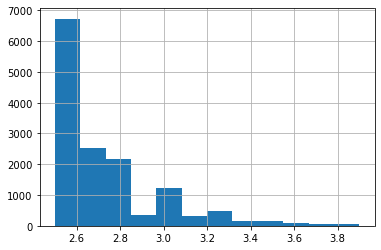

In [8]:
pre_research(df, 'ceiling_height', 12, 2.5, 3.9)

Заменим выбросы данных на 1 и 99 персентили

In [9]:
df.loc[df['ceiling_height']<df['ceiling_height'].quantile(.1),
           'ceiling_height'] = df['ceiling_height'].quantile(.1)
df.loc[df['ceiling_height']>df['ceiling_height'].quantile(.99),
           'ceiling_height'] = df['ceiling_height'].quantile(.99)

Следующий тсолбец: floors_total - всего этажей в доме

Уникальные значения floors_total: 
 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 33. 34. 35. 36. 37. 52. 60.
 nan]
1-й персентиль 5.0
99-й персентиль 26.0


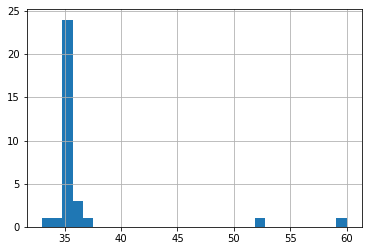

In [10]:
pre_research(df, 'floors_total', 30, 33,60)


Все значения > 40 этажа заменим на NaN для дальнейшего заполнения медианными или средними значениями 

В данном случае заменить выбросы на персентили будет некорректно,
так как здания ниже 5 этажа - это нормальное значение,
а в области 35 этажа свормировано локальное нормальное распределение) 

In [11]:
df.loc[(df['floors_total']>40) , 'floors_total'] = np.nan


Следующий столбец: living_area - жилая площадь в квадратных метрах(м²)

Уникальные значения living_area: 
 [  2.    3.    5.  ... 409.  409.7   nan]
1-й персентиль 16.4
99-й персентиль 120.0


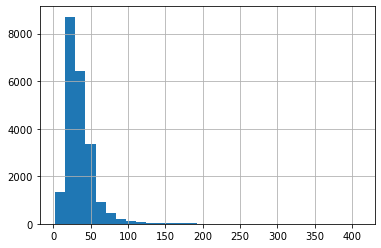

In [12]:
pre_research(df, 'living_area', 30)


Минимальная площадь явно ведет себя странно,
заменим значения до 1-го персентиля на значения
NaN для дальнейшего заполнения средним или медианным 

In [13]:
df.loc[(df['living_area']<df['living_area'].quantile(.1)) , 'living_area'] = np.nan


Следующий столбец: kitchen_area — площадь кухни в квадратных метрах (м²)

Уникальные значения kitchen_area: 
 [  1.3    2.     2.3    2.4    2.89   3.     3.2    3.3    3.4    3.5
   3.7    3.8    4.     4.1    4.2    4.3    4.4    4.5    4.6    4.7
   4.8    4.9    5.     5.04   5.06   5.1    5.14   5.2    5.21   5.23
   5.25   5.28   5.29   5.3    5.31   5.33   5.35   5.4    5.42   5.44
   5.47   5.49   5.5    5.53   5.59   5.6    5.61   5.62   5.64   5.65
   5.68   5.7    5.74   5.75   5.78   5.8    5.82   5.85   5.86   5.9
   5.91   6.     6.02   6.03   6.1    6.16   6.19   6.2    6.22   6.23
   6.24   6.25   6.26   6.27   6.28   6.3    6.31   6.33   6.35   6.36
   6.37   6.4    6.47   6.5    6.55   6.58   6.6    6.61   6.62   6.65
   6.7    6.72   6.73   6.76   6.77   6.8    6.82   6.83   6.84   6.86
   6.9    6.91   6.93   6.95   7.     7.02   7.03   7.06   7.09   7.1
   7.12   7.15   7.17   7.18   7.19   7.2    7.3    7.36   7.4    7.41
   7.48   7.5    7.54   7.6    7.63   7.65   7.7    7.71   7.78   7.8
   7.84   7.85   7.86   7.87   7.89   7.9    7

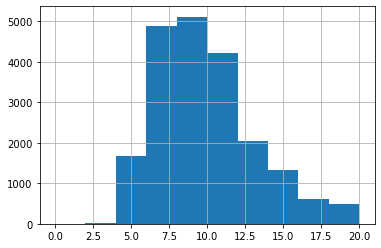

In [14]:
pre_research(df, 'kitchen_area', 10,0,20)



Выглядит неплохо, проверим на соответствие площади квартиры

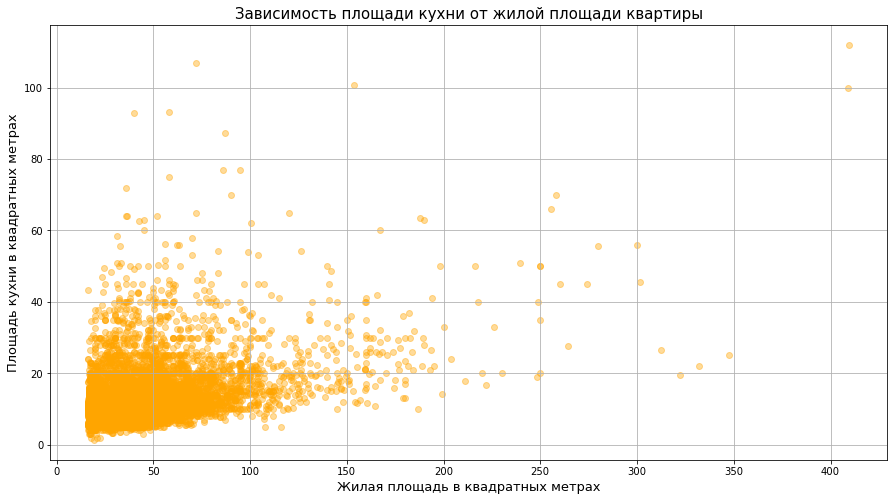

In [15]:
plt.figure(figsize=(15, 8)) 
plt.scatter('living_area', 'kitchen_area', data=df,alpha=0.4,color="orange")
plt.title('Зависимость площади кухни от жилой площади квартиры',fontsize=15)
plt.xlabel('Жилая площадь в квадратных метрах',fontsize=13)
plt.ylabel('Площадь кухни в квадратных метрах',fontsize=13)
plt.grid()
plt.show()

Большая квартира с маленькой кухней - неплохо, большая кухня с маленькой квартирой - нереально.

Заменим значения в которых площадь кухни превышает 70% жилой площади (примерное значение с учетом того, что можно посчитать площадь кухни вместе с совмещенной комнатой)

In [16]:
df.loc[df['kitchen_area']>(df['living_area']*0.7),'kitchen_area'] = df['living_area']*0.7

Проверим график еще раз:ь

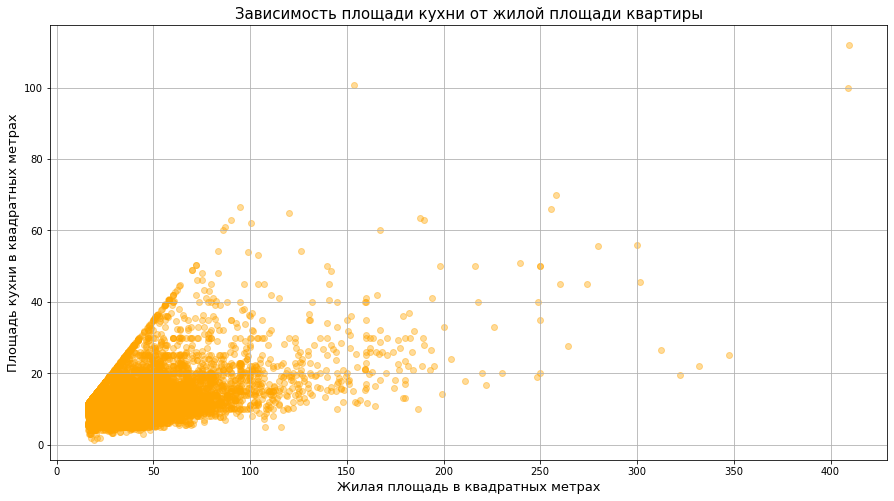

In [17]:
plt.figure(figsize=(15, 8)) 
plt.scatter('living_area', 'kitchen_area', data=df,alpha=0.4,color="orange")
plt.title('Зависимость площади кухни от жилой площади квартиры',fontsize=15)
plt.xlabel('Жилая площадь в квадратных метрах',fontsize=13)
plt.ylabel('Площадь кухни в квадратных метрах',fontsize=13)
plt.grid()
plt.show()

Следующий столбец: balcony — число балконов

Уникальные значения balcony: 
 [ 0.  1.  2.  3.  4.  5. nan]
1-й персентиль 0.0
99-й персентиль 5.0


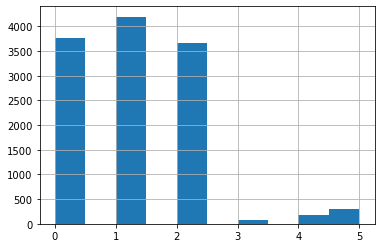

In [18]:
pre_research(df, 'balcony', 10)

Следующий столбец: airports_nearest — расстояние до ближайшего аэропорта в метрах (м)

Уникальные значения airports_nearest: 
 [    0.  6450.  6914. ... 84853. 84869.    nan]
1-й персентиль 13461.0
99-й персентиль 58544.11999999994


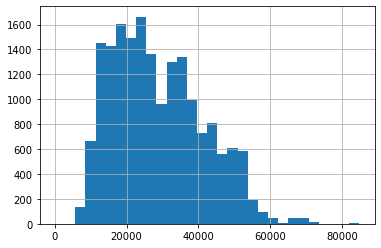

In [19]:
pre_research(df, 'airports_nearest', 30)


Выглядит отлично, есть пики - это скорее всего определенные районы города, в которых сдаются квартиры

Следующий столбец: cityCenters_nearest — расстояние до центра города (м)

Уникальные значения cityCenters_nearest: 
 [  181.   208.   215. ... 65952. 65968.    nan]
1-й персентиль 4766.0
99-й персентиль 50064.63


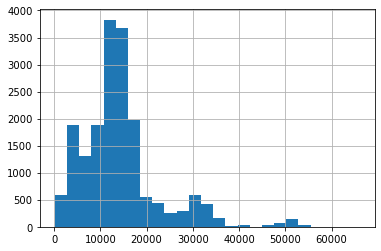

In [20]:
pre_research(df, 'cityCenters_nearest', 25)


Самая большая протяженность непосредственно Санкт-Петербурга - 44км, расстояние в 66км от центра может быть при сдаче жилья в деревне (возможно)

Следующий столбец: parks_around3000 — число парков в радиусе 3 км

Уникальные значения parks_around3000: 
 [ 0.  1.  2.  3. nan]
1-й персентиль 0.0
99-й персентиль 3.0


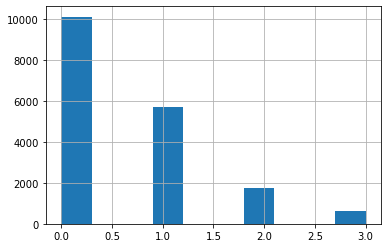

In [21]:
pre_research(df, 'parks_around3000', 10)


Все ок, пропуски заполним 0, если не указано значение, значит его намерено пропустили

Следующий столбец: parks_nearest — расстояние до ближайшего парка (м)

Уникальные значения parks_nearest: 
 [1.000e+00 3.000e+00 4.000e+00 7.000e+00 9.000e+00 1.000e+01 1.100e+01
 1.200e+01 1.300e+01 1.400e+01 1.500e+01 1.600e+01 1.700e+01 1.800e+01
 1.900e+01 2.000e+01 2.100e+01 2.200e+01 2.300e+01 2.400e+01 2.700e+01
 2.800e+01 3.000e+01 3.200e+01 3.300e+01 3.400e+01 3.500e+01 3.600e+01
 3.700e+01 3.800e+01 3.900e+01 4.000e+01 4.100e+01 4.200e+01 4.300e+01
 4.400e+01 4.500e+01 4.600e+01 4.700e+01 4.800e+01 4.900e+01 5.000e+01
 5.100e+01 5.200e+01 5.300e+01 5.400e+01 5.500e+01 5.600e+01 5.700e+01
 5.800e+01 5.900e+01 6.000e+01 6.100e+01 6.200e+01 6.300e+01 6.400e+01
 6.500e+01 6.600e+01 6.700e+01 6.800e+01 6.900e+01 7.100e+01 7.200e+01
 7.300e+01 7.400e+01 7.500e+01 7.600e+01 7.700e+01 7.800e+01 8.000e+01
 8.100e+01 8.200e+01 8.300e+01 8.400e+01 8.500e+01 8.600e+01 8.700e+01
 8.800e+01 9.000e+01 9.100e+01 9.200e+01 9.300e+01 9.400e+01 9.500e+01
 9.600e+01 9.700e+01 9.800e+01 9.900e+01 1.000e+02 1.010e+02 1.020e+02
 1.030e+02 1.040e+02 1.050e+02 1.060e+02

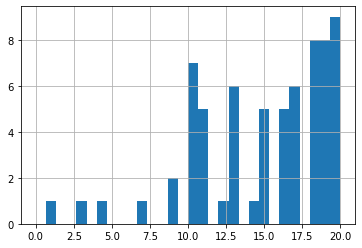

In [22]:
pre_research(df, 'parks_nearest', 30, 0, 20)


Значения 1-9 метров можно было бы удалить, 
но скорее всего люди хотели выделить то, что до парка 
"рукой подать", приравняем к 10 метрам

In [23]:
df.loc[df['parks_nearest']<10 , 'parks_nearest'] = 10


Следующий столбец: ponds_around3000 — число водоёмов в радиусе 3 км

Уникальные значения ponds_around3000: 
 [ 0.  1.  2.  3. nan]
1-й персентиль 0.0
99-й персентиль 3.0


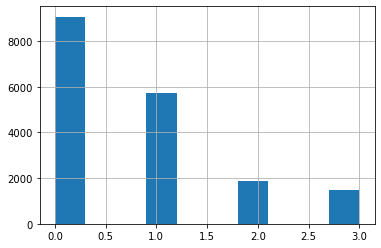

In [24]:
pre_research(df, 'ponds_around3000', 10)

# Просто добавь воды) 

Следующий столбец: ponds_nearest — расстояние до ближайшего водоёма (м)

Уникальные значения ponds_nearest: 
 [  13.   16.   19. ... 1341. 1344.   nan]
1-й персентиль 145.0
99-й персентиль 1159.0


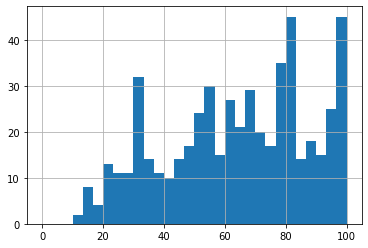

In [25]:
pre_research(df, 'ponds_nearest', 30, 0, 100)

# Кому-то очень удобно подцеплять русалок, выглядит нормально

Следующий столбец: days_exposition — сколько дней было размещено объявление (от публикации до снятия)

Уникальные значения days_exposition: 
 [1.000e+00 2.000e+00 3.000e+00 ... 1.572e+03 1.580e+03       nan]
1-й персентиль 17.0
99-й персентиль 1068.6599999999962


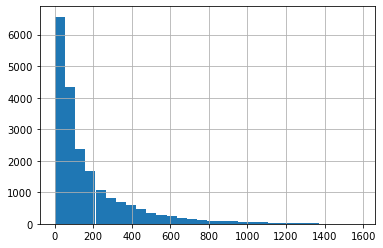

In [26]:
pre_research(df, 'days_exposition', 30)

# А у кого-то очень много терпения и его цену даже рынок не догоняет

Во всех перечисленных столбцах необходимо заменить пропущенные данные средними медианными или нулевыми значениями, для этого будем использовать функцию замены данных с группировкой по нескольким столбцам. 

Так же необходимо привести типы данных в некоторых столбцах к int и bool

In [27]:
df['last_price'] = df['last_price'].astype('int')

Во всех данных для группироваки будем использовать столбец locality_name — название населённого пункта, рассмотрим данный столбец:

In [28]:
df['locality_name'] = df['locality_name'].fillna('не указано')
df['locality_name'] = df['locality_name'].apply(lambda x: x.replace('ё',"е"))

banned = ['поселок городского типа ', 'поселок ','городской ', 'деревня ',
          'садовое товарищество ', 'село ','при железнодорожной станции ','станции ',
         'садоводческое некоммерческое товарищество ', 'имени ','коттеджный ']
for word in banned:
    df['locality_name'] = df['locality_name'].apply(lambda x: x.replace(word,""))
df['locality_name'] = df['locality_name'].str.lower()

Перейдем к заполнению пропусков в данных, еще раз взглянем на наши данные:

In [30]:
df.isna().sum()


total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               88
living_area              4071
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name               0
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

* ceiling_height           9195 пропусков, будем заполнять медианными группируя по значению floor и locality_name
* floors_total               88 пропусков, будем заполнять медианными группируя по значению floor и locality_name
* living_area              4071 пропусков, будем заполнять медианными группируя по значению total_area,balcony и rooms
* is_apartment            20924 пропусков, заменим на 0
* kitchen_area             2278 пропусков, заменим медианными, группируя по значению living_area и total_area
* balcony                 11519 пропусков, заменим на 0
* airports_nearest         5542 пропусков, будем заполнять медианным группируя по значению locality_name
* cityCenters_nearest      5519 пропусков, будем заполнять медианным группируя по значению locality_name
* parks_around3000         5518 пропусков, будем заполнять 0
* parks_nearest           15620 пропусков, будем заполнять медианным группируя по значениям cityCenters_nearest и airports_nearest отдельно
* ponds_around3000         5518 пропусков, будем заполнять 0
* ponds_nearest           14589 пропусков, будем заполнять медианным группируя по значениям cityCenters_nearest и airports_nearest отдельно
* days_exposition          3181 пропусков, заполним в дальнейшем в соответствии с столбцом first_day_exposition


In [31]:
# Для заполнения пропусков будем использовать функцию fills_good

fills_good(df, 'ceiling_height', 'median', ['locality_name', 'floor'])
# Так как не все значения locality_name имеют группировку по этажу
# используем функцию второй раз только с locality_name и далее
# используем заполнение пропусков медианным значением по всем данным
fills_good(df, 'ceiling_height', 'median', ['locality_name'])
df['ceiling_height'] = df['ceiling_height'].fillna(df['ceiling_height'].median())



In [32]:
fills_good(df, 'floors_total', 'median', ['locality_name','floor'])
fills_good(df, 'floors_total', 'median', ['locality_name'])


In [33]:
df['balcony'] = df['balcony'].fillna(0)

In [34]:
fills_good(df, 'living_area', 'median', ['total_area','balcony','rooms'])
fills_good(df, 'living_area', 'median', ['balcony','rooms'])

In [35]:
df['is_apartment'] = df['is_apartment'].fillna(False)

In [36]:
fills_good(df, 'kitchen_area', 'median', ['living_area','total_area'])
fills_good(df, 'kitchen_area', 'median', ['living_area'])
fills_good(df, 'kitchen_area', 'median', ['locality_name'])
df['kitchen_area'] = df['kitchen_area'].fillna(df['kitchen_area'].median())


In [37]:
fills_good(df, 'airports_nearest', 'median', 'locality_name')

In [38]:
fills_good(df, 'cityCenters_nearest', 'median', 'locality_name')

In [39]:
df['parks_around3000'] = df['parks_around3000'].fillna(0)

In [40]:
fills_good(df, 'parks_nearest', 'median', ['airports_nearest'])
fills_good(df, 'parks_nearest', 'median', ['cityCenters_nearest'])

In [41]:
df['ponds_around3000'] = df['ponds_around3000'].fillna(0)

In [42]:
fills_good(df, 'ponds_nearest', 'median', ['airports_nearest'])
fills_good(df, 'ponds_nearest', 'median', ['cityCenters_nearest'])

In [43]:
df.balcony = df.balcony.astype('int')
df.floors_total = df.floors_total.astype('int')


In [44]:
# Приведем столбец first_day_exposition к формату даны и времени

df['first_day_exposition']=pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

In [45]:
df['first_day_exposition']

0       2019-03-07
1       2018-12-04
2       2015-08-20
3       2015-07-24
4       2018-06-19
           ...    
23694   2017-03-21
23695   2018-01-15
23696   2018-02-11
23697   2017-03-28
23698   2017-07-21
Name: first_day_exposition, Length: 23699, dtype: datetime64[ns]

In [46]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  int64         
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        23699 non-null  float64       
 6   floors_total          23699 non-null  int64         
 7   living_area           23699 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          23699 non-null  bool          
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          23699 non-null  float64       
 13  balcony         

| Столбец        | Замена типа           | Пропуски  |
| ------------- |:-------------:| -----:|
|  total_images     | не требуется | не требуется |
| last_price	 | int    |    не требуется |
| total_area	 | не требуется    |    не требуется |
| first_day_exposition | datetime     |    не требуется |
| rooms | не требуется     |    не требуется |
| ceiling_height | не требуется     |    median |
| floors_total | int     |    median |
| living_area | не требуется     |    median |
| floor | int     |    не требуется |
| is_appartment     | bool      |   False |
| studio     | не требуется      |   не требуется |
| open_plan     | не требуется      |   не требуется |
| kitchen_area     | не требуется      |   median |
| balcony     | int | 0 |
| locality_name     | нормализация | не требуется |
| airports_nearest     | не требуется | median |
| cityCenters_nearest     | не требуется | median |
| parks_around3000     | не требуется | median |
| parks_nearest     | не требуется | median |
| ponds_around3000     | не требуется | median |
| ponds_nearest     | не требуется | median |
| days_expoition | int     |    не требуется |


### Вывод

* Все возможные пропуски значений заполнены в соответствии с медианными значениями по определенной группировке для каждой позиции;
* Группировку применяли итерационно, он частных групп к общим, чтобы как можно более точно заполнить отсутствующие значения;
* Такие значения как balcony, is_apartment, parks_around3000 и ponds_around3000 заменили цифрой 0, так как скорее всего при заполнении объявления пользователь пропускает этот параметр при отсуствии такового в квартире
* Все значения связанные с близостью расположения тех или иных объектов оставили без заполнения так как нет возможности определить данные занчения относительно других.
* значения days_exposition оставим не заполненными, скорее всего эти объявления не сняли с публикации
* Столбец first_day_exposition переведен в формата даты и времени

## Расчёты и добавление результатов в таблицу

In [47]:
# Посчитаем цену квадратного метра:

df['meter_price'] = df['last_price']/df['total_area']

In [48]:
# Добавим день недели, месяц и год публикации объявления:

df['day_of_week_exp'] = df['first_day_exposition'].dt.weekday
df['mounth_of_exp'] = df['first_day_exposition'].dt.month
df['year_of_exp'] = df['first_day_exposition'].dt.year

In [49]:
# Добавим категории этажей квартиры — первый, последний, другой:

df['floor_category'] = df['floor']
df.loc[df['floor_category']==1,'floor_category'] = 'Первый'
df.loc[df['floors_total']==df['floor_category'],'floor_category'] = 'Последний'
df.loc[(df['floor_category']!='Первый')&(df['floor_category']!='Последний'),
      'floor_category'] = 'Другой'

In [50]:
# Добавим отношение жилой площади к общей и площади кухни к общей площади:

df['living_to_total'] = df['living_area']/df['total_area']
df['kitchen_to_total'] = df['kitchen_area']/df['total_area']


## Исследовательский анализ данных

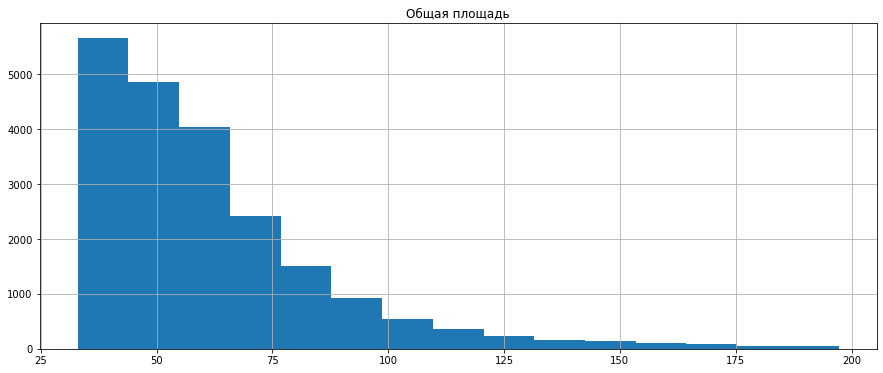

Среднее значение: 60.35
Медианное значение: 52.0


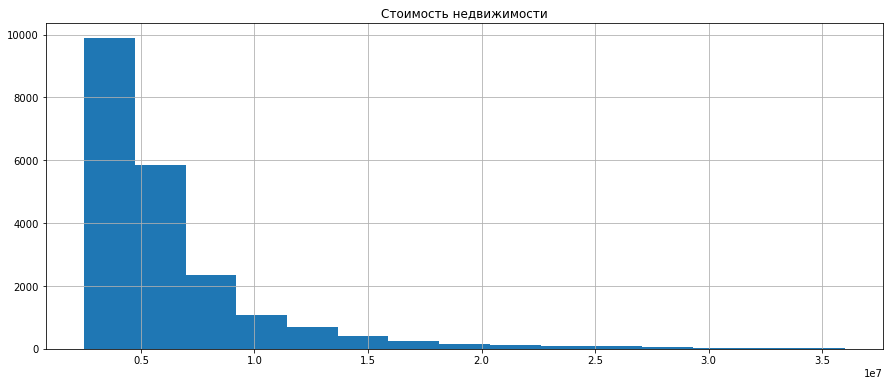

Среднее значение: 6541548.77
Медианное значение: 4650000.0


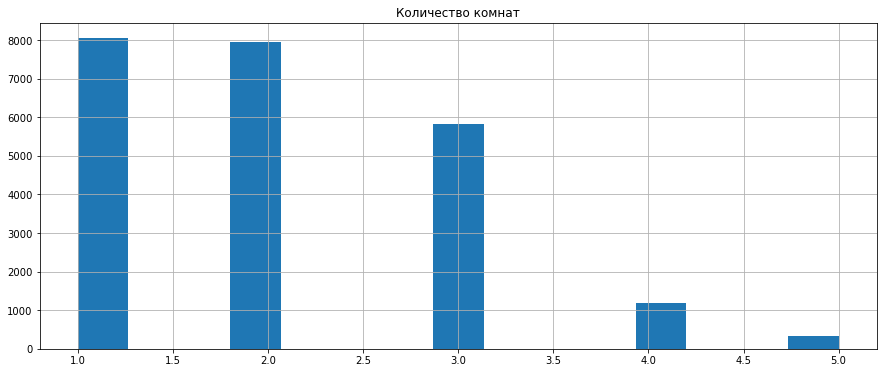

Среднее значение: 2.07
Медианное значение: 2.0


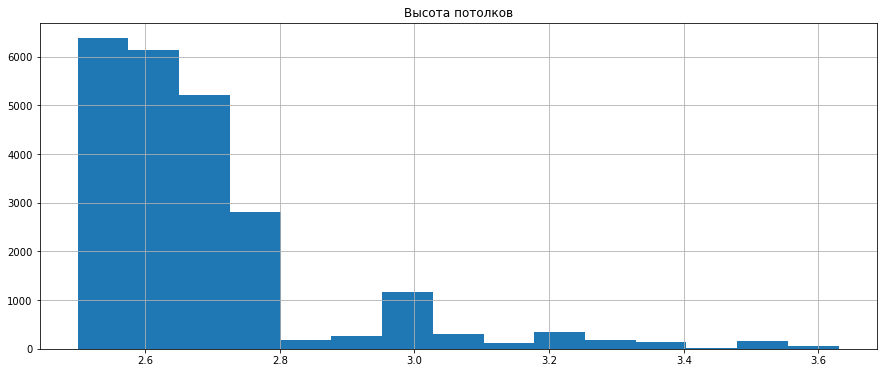

Среднее значение: 2.7
Медианное значение: 2.65


In [51]:
titles = {'total_area': 'Общая площадь', 
          'last_price': 'Стоимость недвижимости',
          'rooms': 'Количество комнат',
          'ceiling_height': 'Высота потолков'}
for i in [df['total_area'],df['last_price'],df['rooms'],df['ceiling_height']]:
    print_hist(i,15, titles[i.name])

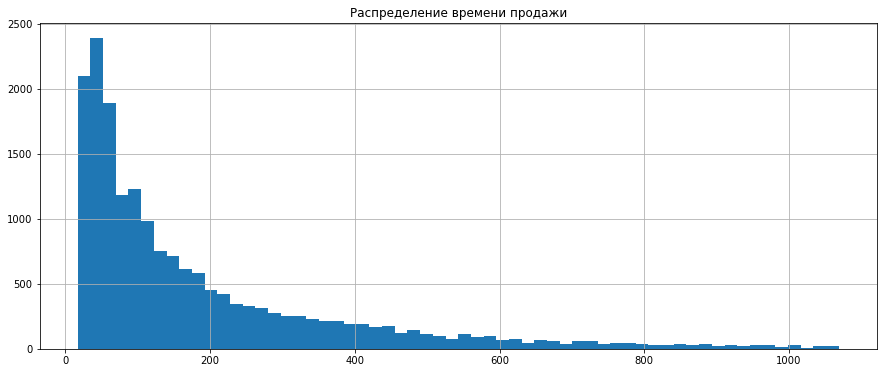

Среднее значение: 180.89
Медианное значение: 95.0


In [52]:
print_hist(df['days_exposition'],60, 'Распределение времени продажи')


Количество времени, необходимого для продажи квартиры будем считать по медианному значению, так как много объявлений не снимается с публикации и имеется большое количество больших значений

Время, необходимое для продажи недвижимости - 95 дней. (исходя из медианного значения)

Построим ящик с усами для колтичества дней публикации объявления


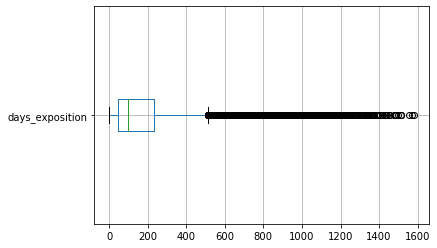

In [53]:
df.boxplot(column='days_exposition',
          vert=False, )
plt.show()

Из представленного графика можно сделать вывод, что все значения столбца 'days_exposition' > 500 - выбросы.

Сравним ящик с усами с гистограммой распределения частот

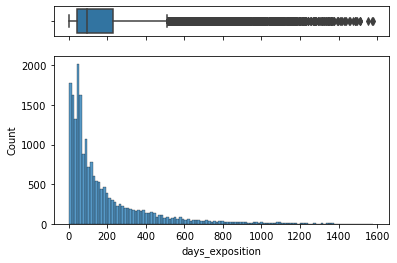

In [54]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
sns.boxplot(data=df, x="days_exposition", ax=ax_box)
sns.histplot(data=df, x="days_exposition", ax=ax_hist)
ax_box.set(xlabel='')
plt.show()

Так же построим скрипичный график для наглятности

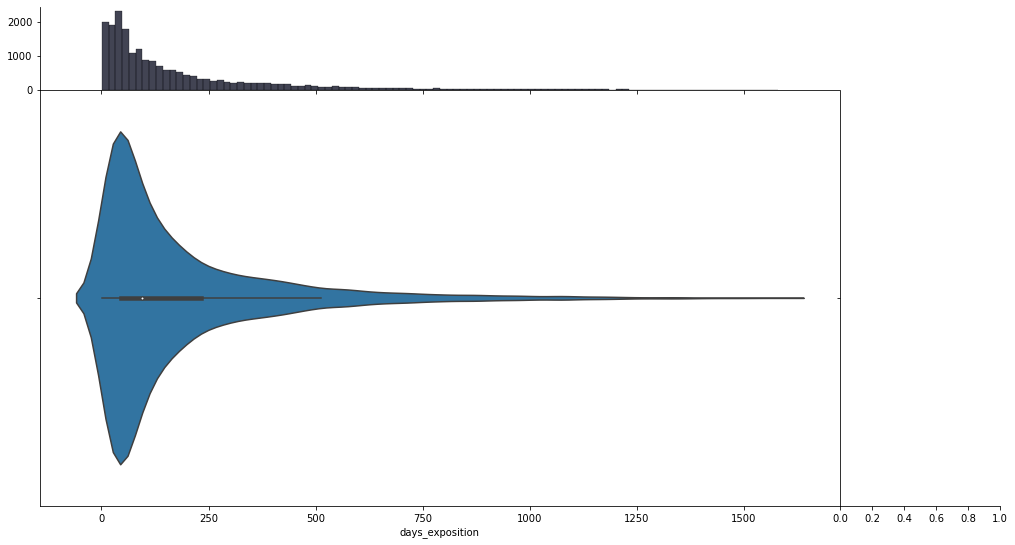

In [55]:
g = sns.JointGrid(data=df, x="days_exposition", space = 0,ratio=5, marginal_ticks=True)
g.plot_joint(sns.violinplot)
g.plot_marginals(sns.histplot, color="#03051A", bins=100)
g.fig.set_size_inches(15,8)


Вплоть до 500 дней на графиках видно довольно заметное плато, которое затем идет на спад, скорее всего это объявления, которые забыли снять с публикации, отсечем эти данные, обрезав датафрейм на 99м персентиле

In [56]:
print(f"Продажа прошла очень быстро, если объявление снято в течение: {round(df['days_exposition'].quantile(.25),1)} дней")
print(f"Продажа длилась очень долго, если объявление снято в течение: {round(df['days_exposition'].quantile(.75),1)} дней")


Продажа прошла очень быстро, если объявление снято в течение: 45.0 дней
Продажа длилась очень долго, если объявление снято в течение: 232.0 дней


Скопируем наш датафрейм и удалим из него все выбивающиеся значения:

In [57]:
df_n = df.copy()
df_n = df_n.drop(df_n[df_n['last_price']>df['last_price'].quantile(.99)].index)
df_n = df_n.drop(df_n[df_n['meter_price']>df['meter_price'].quantile(.99)].index)
df_n = df_n.drop(df_n[df_n['total_area']>df['total_area'].quantile(.99)].index)
df_n = df_n.drop(df_n[df_n['days_exposition']>df['days_exposition'].quantile(.99)].index)


In [58]:
df_n

total_images  last_price  total_area first_day_exposition  rooms  \
0                20    13000000      108.00           2019-03-07      3   
1                 7     3350000       40.40           2018-12-04      1   
2                10     5196000       56.00           2015-08-20      2   
4                 2    10000000      100.00           2018-06-19      2   
5                10     2890000       30.40           2018-09-10      1   
...             ...         ...         ...                  ...    ...   
23694             9     9700000      133.81           2017-03-21      3   
23695            14     3100000       59.00           2018-01-15      3   
23696            18     2500000       56.70           2018-02-11      2   
23697            13    11475000       76.75           2017-03-28      2   
23698             4     1350000       32.30           2017-07-21      1   

       ceiling_height  floors_total  living_area  floor  is_apartment  ...  \
0                2.70            16        51.00      8         False  ...   
1                2.60            11        18.60      1         False  ...   
2                2.70             5        34.30      4         False  ...   
4                3.03            14        32.00     13         False  ...   
5                2.70            12        17.40      5         False  ...   
...               ...           ...          ...    ...           ...  ...   
23694            3.70             5        73.30      3         False  ...   
23695            2.55             5        38.00      4         False  ...   
23696            2.65             3        29.70      1         False  ...   
23697            3.00            17        31.00     12         False  ...   
23698            2.50             5        17.75      1         False  ...   

       ponds_around3000  ponds_nearest  days_exposition    meter_price  \
0                   2.0          755.0              NaN  120370.370370   
1                   0.0            NaN             81.0   82920.792079   
2                   2.0          574.0            558.0   92785.714286   
4                   1.0           48.0            121.0  100000.000000   
5                   0.0            NaN             55.0   95065.789474   
...                 ...            ...              ...            ...   
23694               3.0          381.0              NaN   72490.845228   
23695               0.0            NaN             45.0   52542.372881   
23696               0.0            NaN              NaN   44091.710758   
23697               3.0          196.0            602.0  149511.400651   
23698               0.0            NaN              NaN   41795.665635   

      day_of_week_exp  mounth_of_exp  year_of_exp  floor_category  \
0                   3              3         2019          Другой   
1                   1             12         2018          Первый   
2                   3              8         2015          Другой   
4                   1              6         2018          Другой   
5                   0              9         2018          Другой   
...               ...            ...          ...             ...   
23694               1              3         2017          Другой   
23695               0              1         2018          Другой   
23696               6              2         2018          Первый   
23697               1              3         2017          Другой   
23698               4              7         2017          Первый   

       living_to_total  kitchen_to_total  
0             0.472222          0.231481  
1             0.460396          0.272277  
2             0.612500          0.148214  
4             0.320000          0.224000  
5             0.572368          0.299342  
...                ...               ...  
23694         0.547792          0.103356  
23695         0.644068          0.144068  
23696         0.523810          0.137566  
23697         0.40390

In [59]:
df_n.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23052 entries, 0 to 23698
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23052 non-null  int64         
 1   last_price            23052 non-null  int64         
 2   total_area            23052 non-null  float64       
 3   first_day_exposition  23052 non-null  datetime64[ns]
 4   rooms                 23052 non-null  int64         
 5   ceiling_height        23052 non-null  float64       
 6   floors_total          23052 non-null  int64         
 7   living_area           23052 non-null  float64       
 8   floor                 23052 non-null  int64         
 9   is_apartment          23052 non-null  bool          
 10  studio                23052 non-null  bool          
 11  open_plan             23052 non-null  bool          
 12  kitchen_area          23052 non-null  float64       
 13  balcony         

Проведем поверхностный статистический анализ данных, необходимо понять можно ли найти явные закономерности в представленных данных.

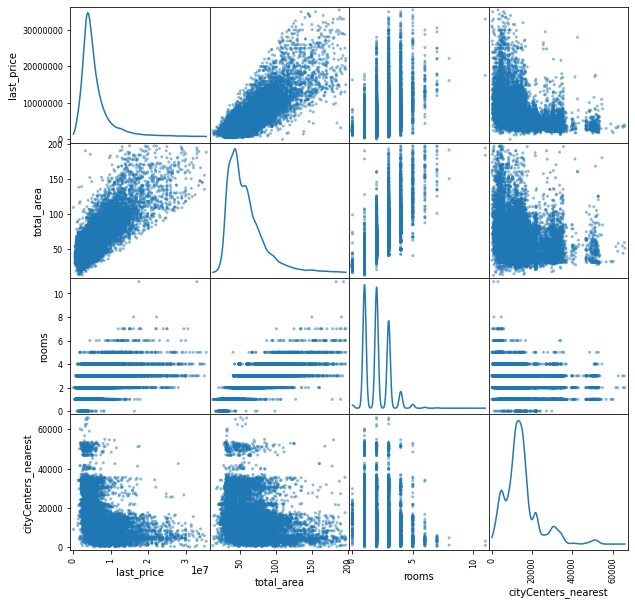

In [60]:
print_matrix(df_n,  
             ['last_price','total_area', 
              'rooms',
              'cityCenters_nearest',
              ],10,10)


Из матрицы диаграмм рассеяния видно, что облака точек очень большие и довольно тяжело определить корреляцию некоторых комбинаций данных между собой.

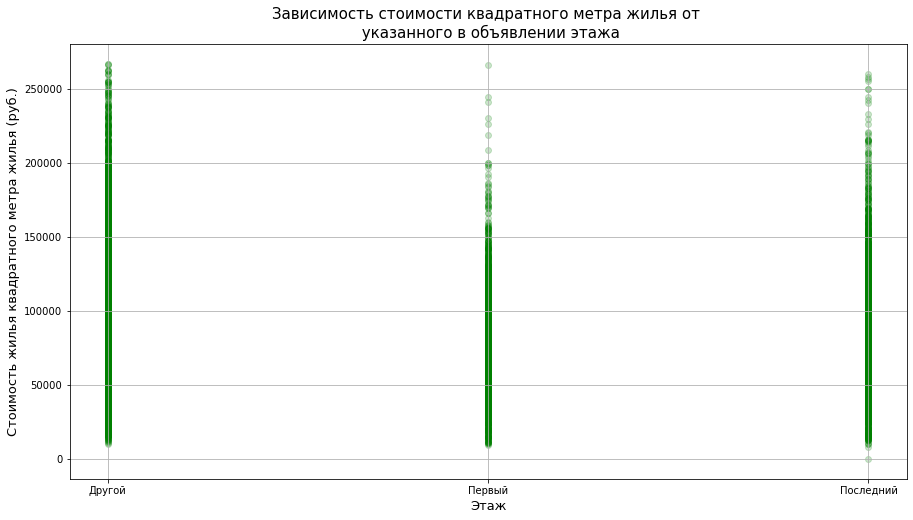

In [61]:
labels = ['Зависимость стоимости квадратного метра жилья от \n указанного в объявлении этажа',
          'Этаж','Стоимость жилья квадратного метра жилья (руб.)']
print_scatter(df_n, 'floor_category', 'meter_price', labels)

Явно видно, что первый этаж реже и дешевле, чем другие этажи

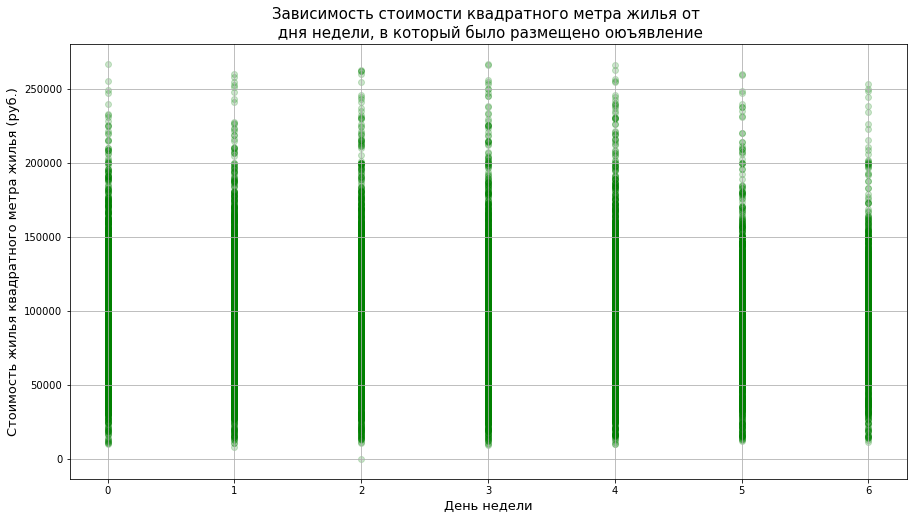

In [62]:
labels = ['Зависимость стоимости квадратного метра жилья от \n дня недели, в который было размещено оюъявление',
          'День недели','Стоимость жилья квадратного метра жилья (руб.)']
print_scatter(df_n, 'day_of_week_exp', 'meter_price', labels)

В субботу и воскресенье выкладывают самые дешевые объявления, хотя из-за плотности данных довольно сложно определить закономерности

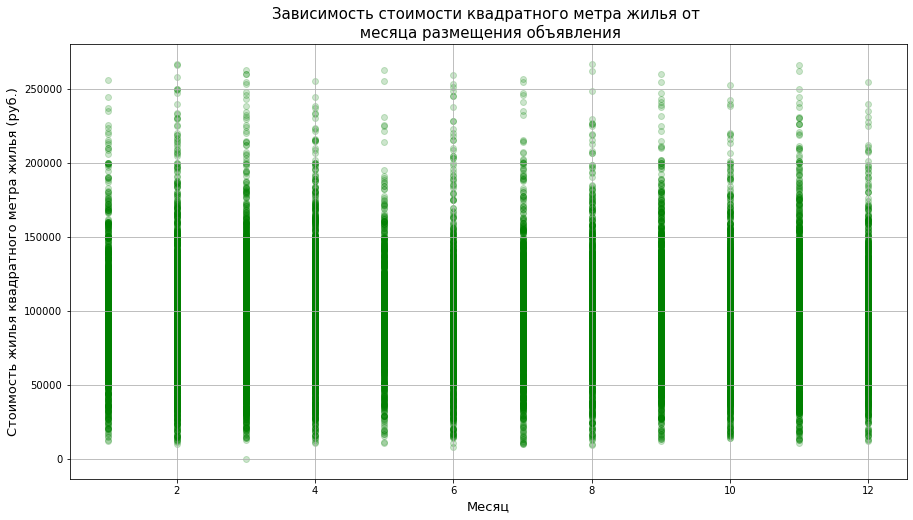

In [63]:
labels = ['Зависимость стоимости квадратного метра жилья от \n месяца размещения объявления',
          'Месяц','Стоимость жилья квадратного метра жилья (руб.)']
print_scatter(df_n, 'mounth_of_exp', 'meter_price', labels)


Данные распределены почти равномерно, как и в предыдущих случаях, явной закономерности не выявлено.

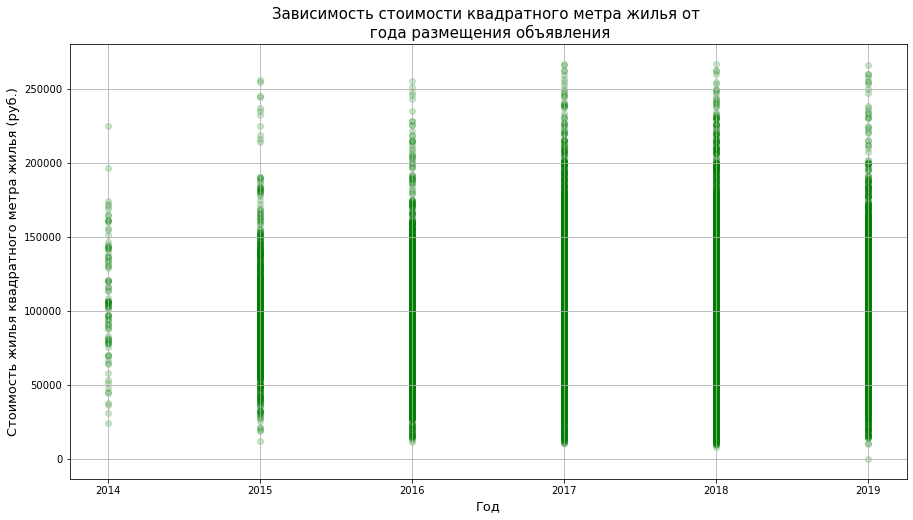

In [64]:
labels = ['Зависимость стоимости квадратного метра жилья от \n года размещения объявления',
          'Год','Стоимость жилья квадратного метра жилья (руб.)']
print_scatter(df_n, 'year_of_exp', 'meter_price', labels)


В 2017 и 2018 года цены на жилья стали явно больше, либо стали продавать больше дорогого жилья

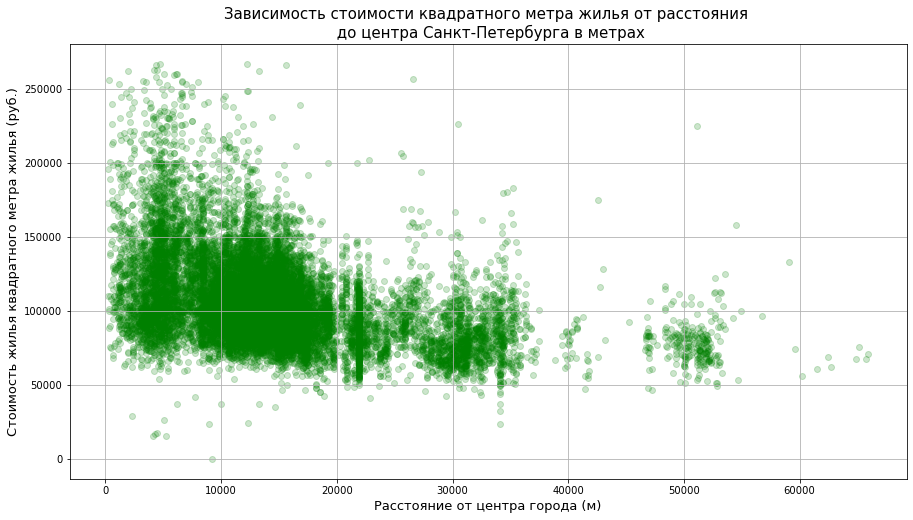

In [65]:
labels = ['Зависимость стоимости квадратного метра жилья от расстояния \n до центра Санкт-Петербурга в метрах',
          'Расстояние от центра города (м)','Стоимость жилья квадратного метра жилья (руб.)']
print_scatter(df_n, 'cityCenters_nearest', 'meter_price', labels)

Из графика можно увидеть очевидные зависимости стоимости квадратного метра жилья от отдаления от центра города, но данные очень разрозненные и довольно трудно оценить основной тренд. 

Построим матрицу коэффициентов корреляции Пирсона для всех вышеуказанных данных:

In [66]:
df_n1 = df_n[['last_price','meter_price','total_area', 
              'rooms',
              'cityCenters_nearest',
              'day_of_week_exp','mounth_of_exp','year_of_exp']].copy()

In [67]:
df_n1.corr()

last_price  meter_price  total_area     rooms  \
last_price             1.000000     0.670957    0.800313  0.508917   
meter_price            0.670957     1.000000    0.166187 -0.063280   
total_area             0.800313     0.166187    1.000000  0.794018   
rooms                  0.508917    -0.063280    0.794018  1.000000   
cityCenters_nearest   -0.356028    -0.411592   -0.237028 -0.173511   
day_of_week_exp       -0.015161    -0.011787   -0.013321 -0.004088   
mounth_of_exp         -0.000264    -0.005648    0.003868 -0.006191   
year_of_exp           -0.019165     0.056951   -0.066363 -0.039437   

                     cityCenters_nearest  day_of_week_exp  mounth_of_exp  \
last_price                     -0.356028        -0.015161      -0.000264   
meter_price                    -0.411592        -0.011787      -0.005648   
total_area                     -0.237028        -0.013321       0.003868   
rooms                          -0.173511        -0.004088      -0.006191   
cityCenters_nearest             1.000000         0.004873      -0.007131   
day_of_week_exp                 0.004873         1.000000       0.010390   
mounth_of_exp                  -0.007131         0.010390       1.000000   
year_of_exp                     0.025078        -0.006791      -0.274675   

                     year_of_exp  
last_price             -0.019165  
meter_price             0.056951  
total_area             -0.066363  
rooms                  -0.039437  
cityCenters_nearest     0.025078  
day_of_week_exp        -0.006791  
mounth_of_exp          -0.274675  
year_of_exp             1.000000

Из матрицы коэффициентов корреляции видно, что коррелируют между собой только значения last_price, meter_price, total_area, rooms.

Возможно, если выбрать более узкий набор данных, то можно более отчетливо выявить зависимости данных

Вычислим топ 10 локаций по количеству объявлений:

In [68]:
top_locations = df_n.groupby('locality_name')['last_price'].count().sort_values(ascending=False)[0:10]
top_locations['locality_name'] = top_locations.index
list_top = top_locations['locality_name']


Сделаем срез данных в отдельный датафрейм по топ 10-ти локациям:


In [69]:
top_locations_df = df_n[df_n['locality_name'].isin(list_top)].copy()
print("Количество объявлений в топ 10 локаций: \n")
print(top_locations)


Количество объявлений в топ 10 локаций: 

locality_name
санкт-петербург                                                15135
мурино                                                           588
кудрово                                                          469
шушары                                                           439
всеволожск                                                       395
пушкин                                                           361
колпино                                                          335
парголово                                                        325
гатчина                                                          307
выборг                                                           237
locality_name      Index(['санкт-петербург', 'мурино', 'кудрово',...
Name: last_price, dtype: object


In [70]:
print("Средняя цена квадратного метра в населенных пунктах с наибольшим количеством объявлений: \n")
print(round(top_locations_df.groupby('locality_name')['meter_price'].mean().sort_values(ascending=False),2))


Средняя цена квадратного метра в населенных пунктах с наибольшим количеством объявлений: 

locality_name
санкт-петербург    109919.85
пушкин             103196.70
кудрово             95299.89
парголово           90259.74
мурино              86143.61
шушары              78635.70
колпино             75279.71
гатчина             68746.15
всеволожск          67227.16
выборг              58141.91
Name: meter_price, dtype: float64


Наибольшая стоимость жилья в Санкт-Петербурге - 109919.85

Наименьшая стоимость жилья в Выборге - 58141.91


Предполагаем, что в Санкт-Петербурге данные будут более заметтно коррелировать и зависимости будут видны гораздо сильнее, поэтому перейдем к срезу данных только по городу Санкт-Петербург:

In [71]:
spb = top_locations_df[top_locations_df['locality_name'] == 'санкт-петербург'].copy()


Разделим город на кольца диаметром 1 километр:

In [72]:
spb['cityCenters_nearest_km'] = spb['cityCenters_nearest']/1000

In [73]:
spb['cityCenters_nearest_km'] = spb['cityCenters_nearest_km'].dropna().astype('int')

In [74]:
spb['cityCenters_nearest_km']

0        16
2        13
4         8
7        11
9        15
         ..
23689    16
23690     6
23691     4
23694     4
23697    10
Name: cityCenters_nearest_km, Length: 15135, dtype: int64

In [75]:
spb_price_km = spb.groupby('cityCenters_nearest_km')['meter_price'].mean()

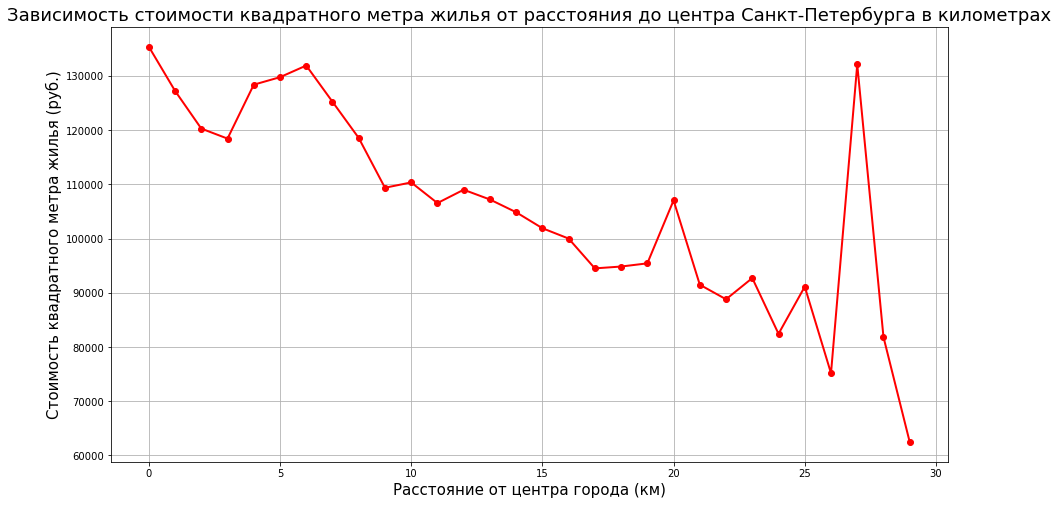

In [76]:
plt.figure(figsize=(15, 8)) 
plt.plot(spb_price_km.index,spb_price_km, marker='o', color='red', linewidth=2)
plt.title('Зависимость стоимости квадратного метра жилья от расстояния до центра Санкт-Петербурга в километрах',fontsize=18)
plt.xlabel('Расстояние от центра города (км)',fontsize=15)
plt.ylabel('Стоимость квадратного метра жилья (руб.)',fontsize=15)
plt.grid()
plt.show()

Из графика видно, что падение стоимости жилья начинается с расстояния 6км от центра города

Выделили центр города, исследуем данные в центре города на те же метрики, которые использовали ранее

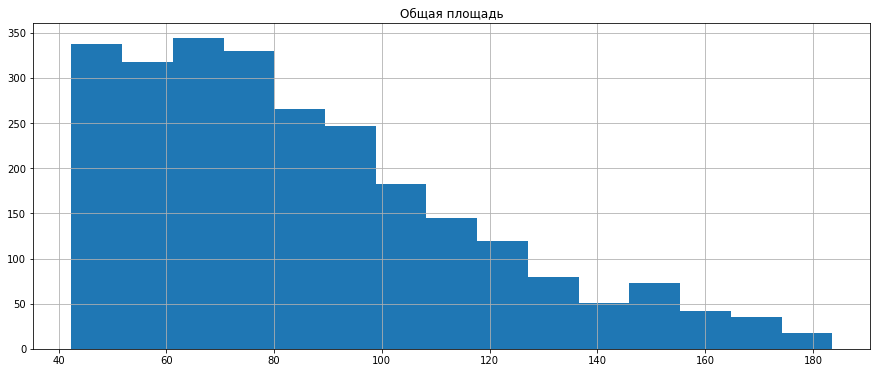

Среднее значение: 81.57
Медианное значение: 75.1


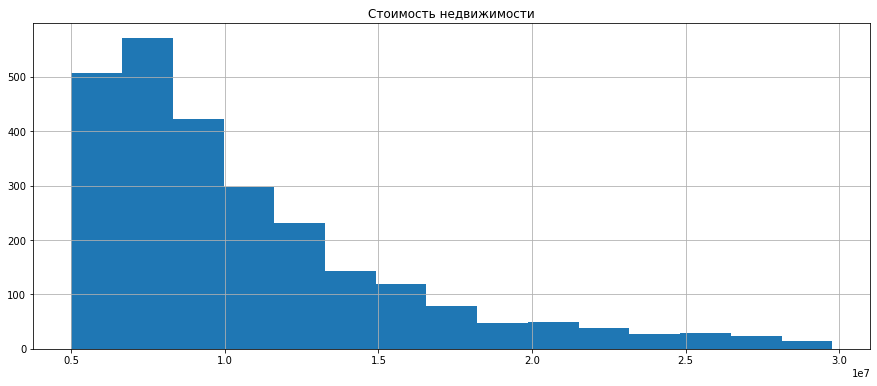

Среднее значение: 10221555.02
Медианное значение: 8600000.0


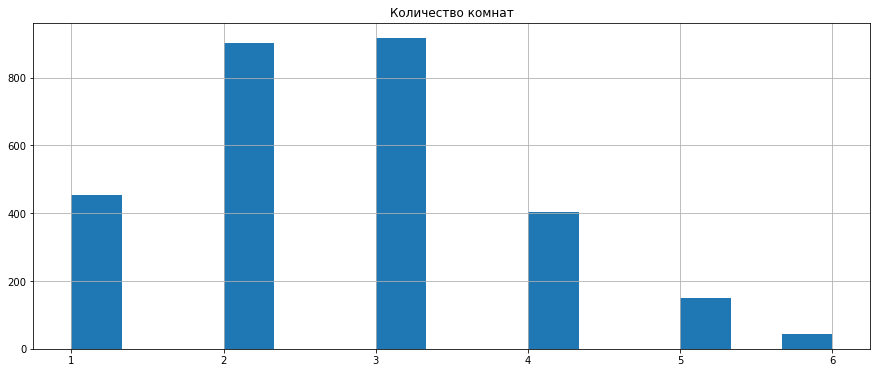

Среднее значение: 2.68
Медианное значение: 3.0


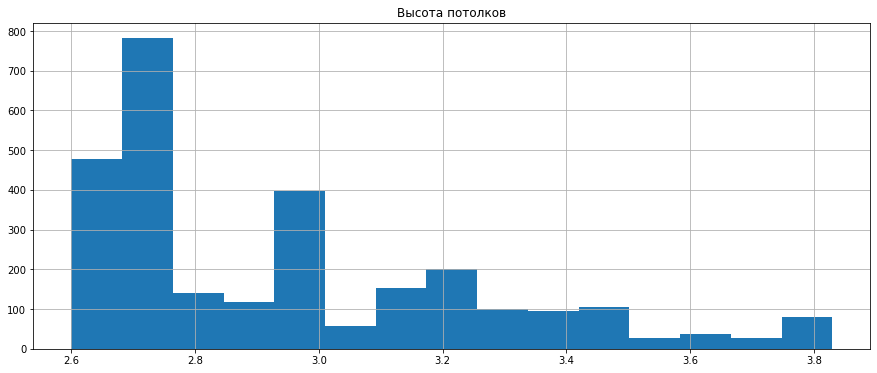

Среднее значение: 2.93
Медианное значение: 2.8


In [77]:
spb_centre = spb[spb['cityCenters_nearest_km']<=6].copy()
# Выделили центр города, исследуем данные в центре города на те же метрики,
# которые использовали ранее
titles = {'total_area': 'Общая площадь', 
          'last_price': 'Стоимость недвижимости',
          'rooms': 'Количество комнат',
          'ceiling_height': 'Высота потолков'}
for i in [spb_centre['total_area'],spb_centre['last_price'],spb_centre['rooms'],spb_centre['ceiling_height']]:
    print_hist(i,15, titles[i.name])

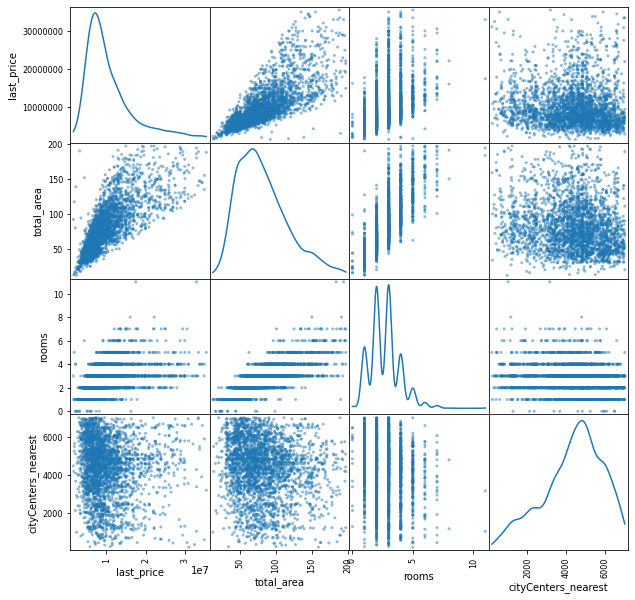

In [78]:
print_matrix(spb_centre,  
             ['last_price','total_area', 
              'rooms',
              'cityCenters_nearest',
              ],10,10)


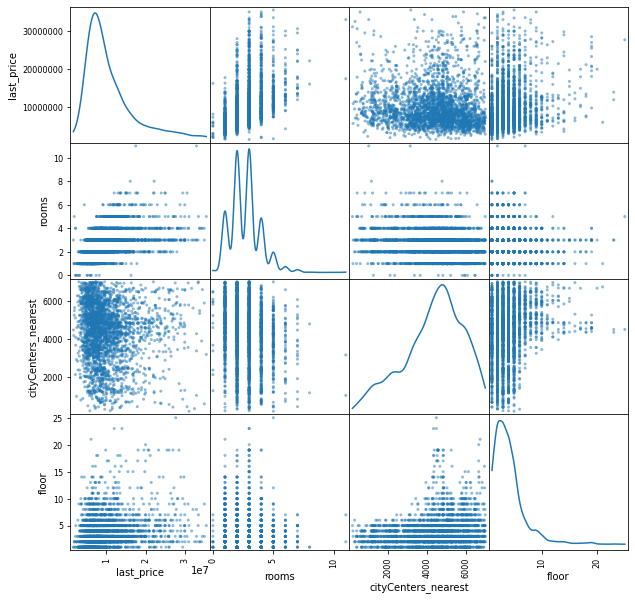

In [79]:
print_matrix(spb_centre,  
             ['last_price','first_day_exposition', 
              'rooms',
              'cityCenters_nearest','floor'
              ],10,10)

Из матрицы диаграмм рассеяния можно заметить, что зависимости между данными прослеживаются более отчетливо, так как мы отсекли все данные, где стоимость квадратного метра жилья отличается от центра города

Построим графики и матрицу коэффициентов корреляции

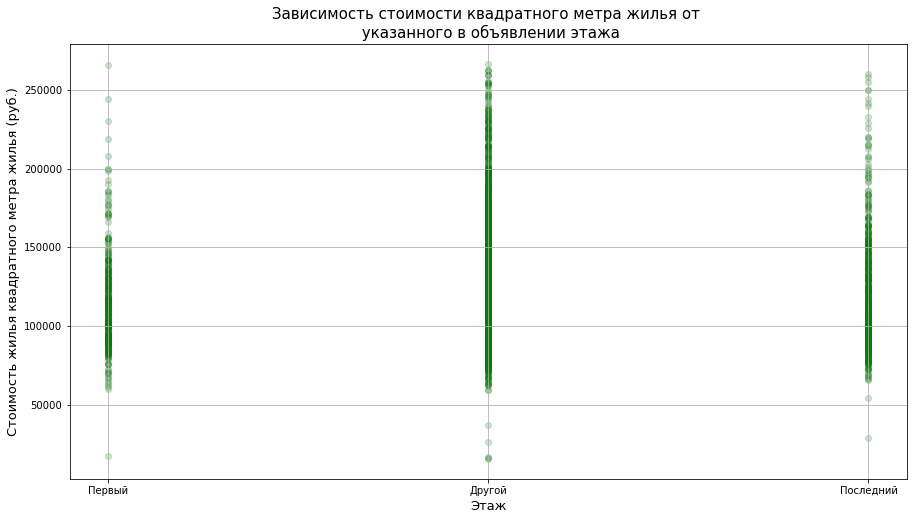

In [80]:
labels = ['Зависимость стоимости квадратного метра жилья от \n указанного в объявлении этажа',
          'Этаж','Стоимость жилья квадратного метра жилья (руб.)']
print_scatter(spb_centre, 'floor_category', 'meter_price', labels)

В центре города совсем не в почете первые этажи - из-за шумных ночных улиц Питера. Последние же этажи не в почете во всех городах, но так же можно предположить, что жителям последних этажей центра Санкт-Петербурга часто мешают любители походить по крышам на рассвете

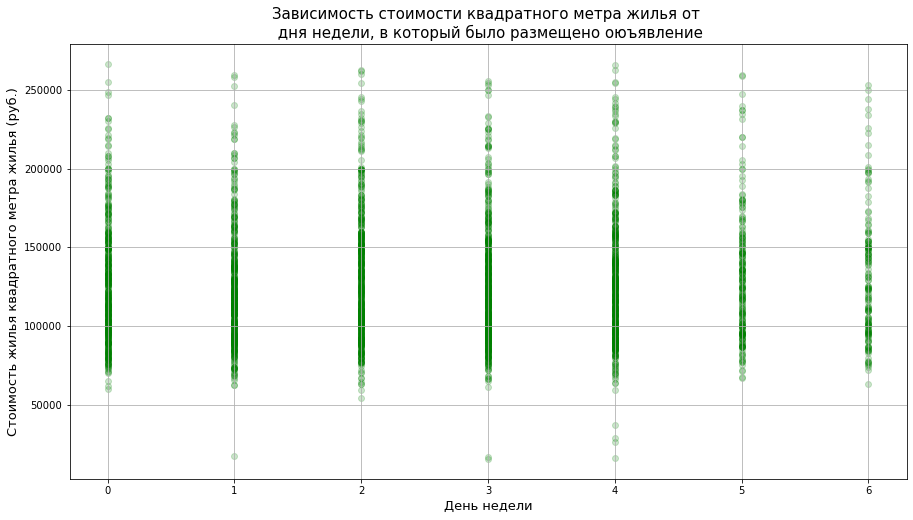

In [81]:
labels = ['Зависимость стоимости квадратного метра жилья от \n дня недели, в который было размещено оюъявление',
          'День недели','Стоимость жилья квадратного метра жилья (руб.)']
print_scatter(spb_centre, 'day_of_week_exp', 'meter_price', labels)

В субботу и воскресенье выкладывают меньше всего объявлений, теперь это отчетливо видно, взаимосвязи между ценой и днем подачи объявления - нет

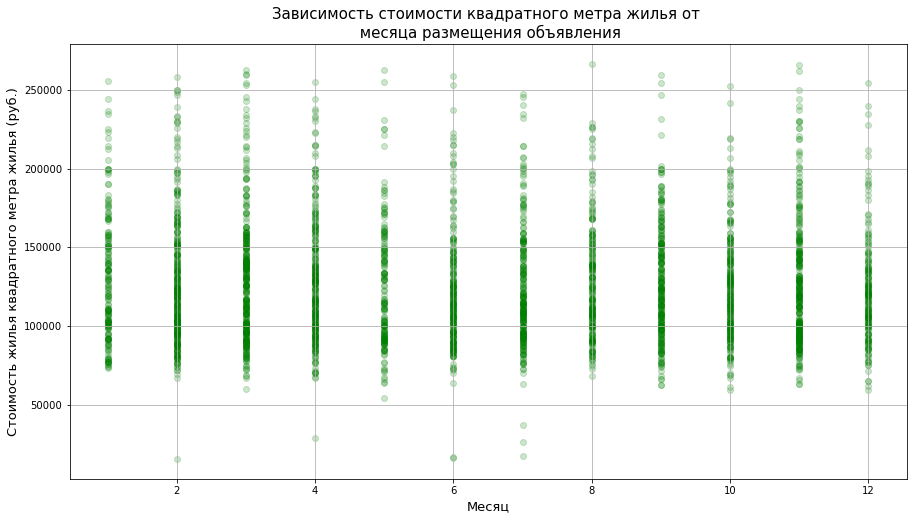

In [82]:
labels = ['Зависимость стоимости квадратного метра жилья от \n месяца размещения объявления',
          'Месяц','Стоимость жилья квадратного метра жилья (руб.)']
print_scatter(spb_centre, 'mounth_of_exp', 'meter_price', labels)


В Мае, летом и на новый год количество объявлений о продаже жилья падает, проверим на гистограме.

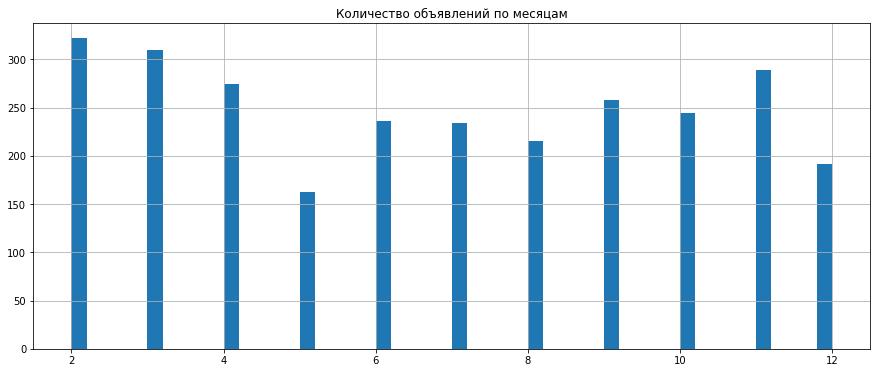

Среднее значение: 6.42
Медианное значение: 6.0


In [83]:
print_hist(spb_centre['mounth_of_exp'],50, 'Количество объявлений по месяцам')

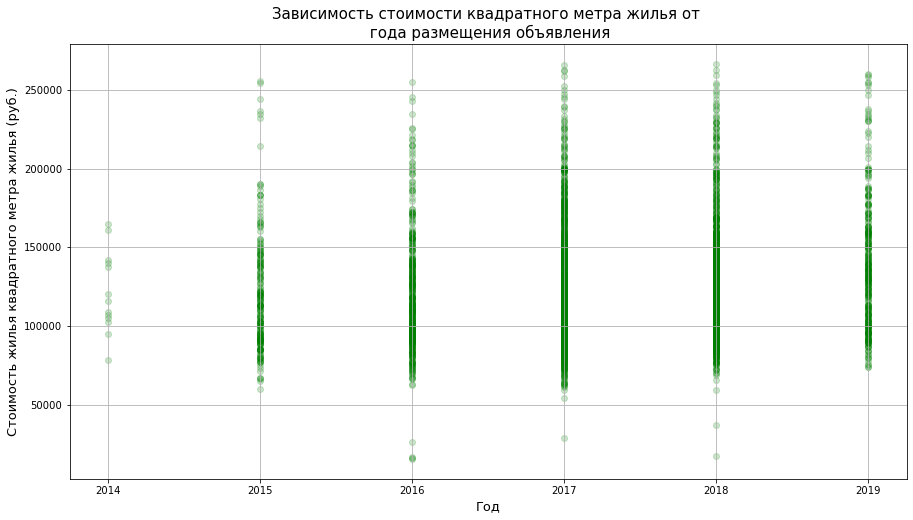

In [84]:
labels = ['Зависимость стоимости квадратного метра жилья от \n года размещения объявления',
          'Год','Стоимость жилья квадратного метра жилья (руб.)']
print_scatter(spb_centre, 'year_of_exp', 'meter_price', labels)


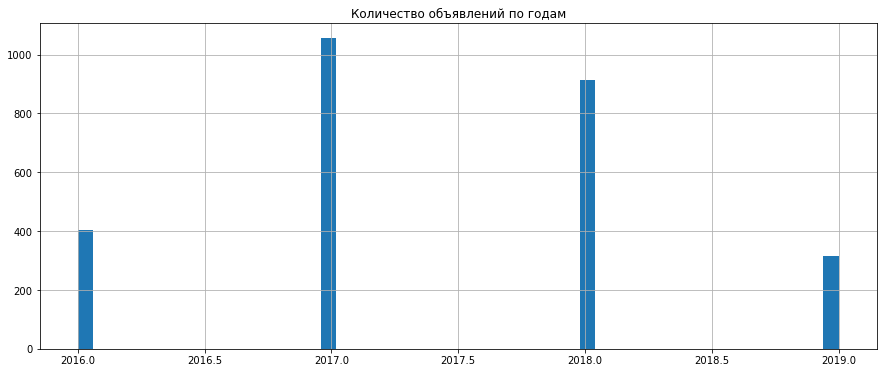

Среднее значение: 2017.24
Медианное значение: 2017.0


In [85]:
print_hist(spb_centre['year_of_exp'],50, 'Количество объявлений по годам')

Из гистограммы складывается ощущение, что в 2016 и 2019 году жилье категорически не хотели продавать, посмотрим на минимальное и максимальные значения подачи объявления:

In [86]:
print(f"Начало временного ряда: {spb_centre['first_day_exposition'].min()}")
print(f"Конец временного ряда: {spb_centre['first_day_exposition'].max()}")

Начало временного ряда: 2014-12-08 00:00:00
Конец временного ряда: 2019-05-03 00:00:00


В 2016 году действительно было мало объявлений на данной площадке, а вот данные за 2019 год кончились на самом интересном месте - в Мае

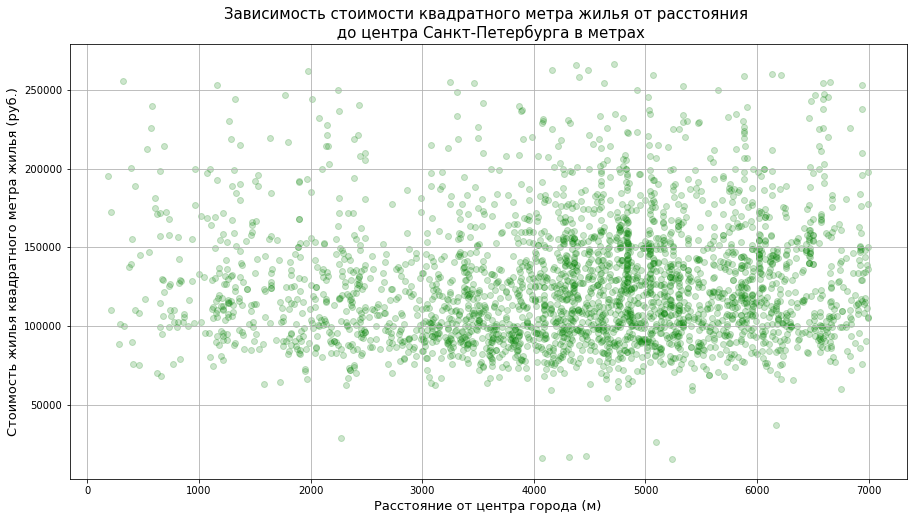

In [87]:
labels = ['Зависимость стоимости квадратного метра жилья от расстояния \n до центра Санкт-Петербурга в метрах',
          'Расстояние от центра города (м)','Стоимость жилья квадратного метра жилья (руб.)']
print_scatter(spb_centre, 'cityCenters_nearest', 'meter_price', labels)

Очевидно, что данные распределеные примерно равномерно, так как мы постарались выбрать квартиры в одном ценовом диапозоне

Построим матрицу коэффициентов корреляции Пирсона для всех вышеуказанных данных:

In [88]:
spb_centre[['last_price','meter_price','total_area', 
              'rooms',
              'cityCenters_nearest',
              'day_of_week_exp','mounth_of_exp','year_of_exp']].corr()

last_price  meter_price  total_area     rooms  \
last_price             1.000000     0.540217    0.750420  0.465521   
meter_price            0.540217     1.000000   -0.095035 -0.275837   
total_area             0.750420    -0.095035    1.000000  0.789317   
rooms                  0.465521    -0.275837    0.789317  1.000000   
cityCenters_nearest   -0.069869     0.064555   -0.155421 -0.198634   
day_of_week_exp        0.003632     0.031607   -0.010930 -0.011681   
mounth_of_exp         -0.044625    -0.037207   -0.037732 -0.038012   
year_of_exp            0.026511     0.125927   -0.057619 -0.030715   

                     cityCenters_nearest  day_of_week_exp  mounth_of_exp  \
last_price                     -0.069869         0.003632      -0.044625   
meter_price                     0.064555         0.031607      -0.037207   
total_area                     -0.155421        -0.010930      -0.037732   
rooms                          -0.198634        -0.011681      -0.038012   
cityCenters_nearest             1.000000        -0.005346      -0.001507   
day_of_week_exp                -0.005346         1.000000       0.028655   
mounth_of_exp                  -0.001507         0.028655       1.000000   
year_of_exp                     0.048682         0.003897      -0.256226   

                     year_of_exp  
last_price              0.026511  
meter_price             0.125927  
total_area             -0.057619  
rooms                  -0.030715  
cityCenters_nearest     0.048682  
day_of_week_exp         0.003897  
mounth_of_exp          -0.256226  
year_of_exp             1.000000

При уменьшении выборки корреляция даже уменьшилась, но она стала точнее, так как данные более однородны, попробуем найти другие взаимосвязи

Достаточно очевидна взаимосвязь между количеством дней, необходимых для продажи квартиры и количеством фотографий в объявлении, проверим этот параметр

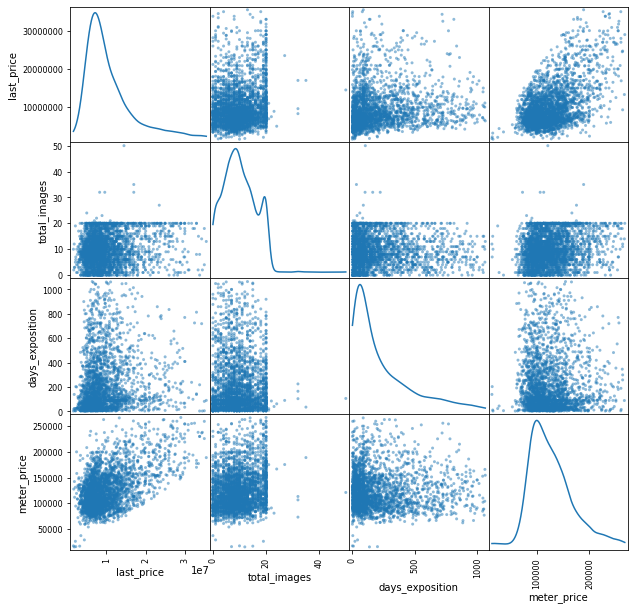

In [89]:
print_matrix(spb_centre,  
             ['last_price','total_images','days_exposition', 
              'meter_price'
              ],10,10)

Уберем выбросы в total_images путем приравнивания их к 20, судя по всему 20 - это максимальное количество изображений в объявлении

In [90]:
spb_centre.loc[spb_centre['total_images']>20, 'total_images'] = 20

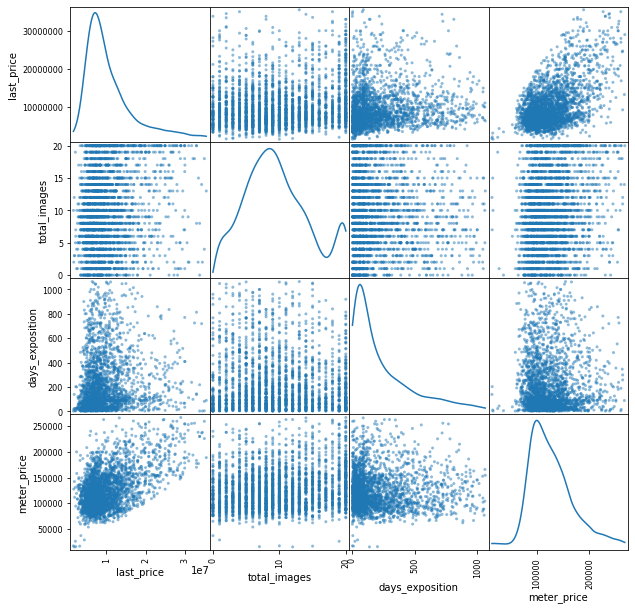

In [91]:
print_matrix(spb_centre,  
             ['last_price','total_images','days_exposition', 
              'meter_price'
              ],10,10)

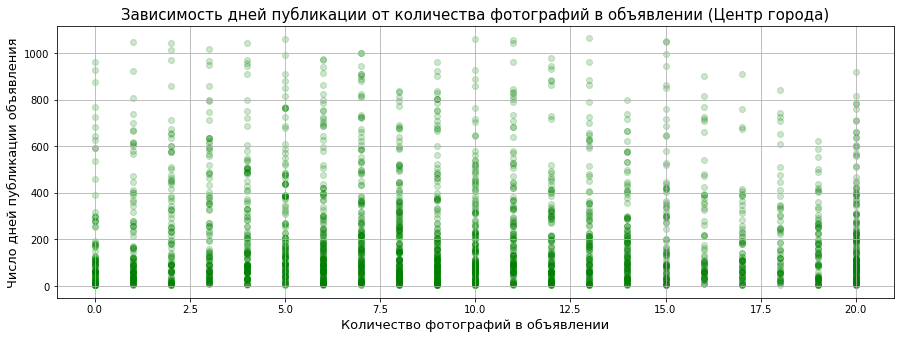

In [92]:
labels = ['Зависимость дней публикации от количества фотографий в объявлении (Центр города)',
          'Количество фотографий в объявлении','Число дней публикации объявления']
print_scatter(spb_centre, 'total_images', 'days_exposition', labels, "g",15,5)

Проверим на общей выборке данных:

In [93]:
df_n.loc[df_n['total_images']>20, 'total_images']= 20

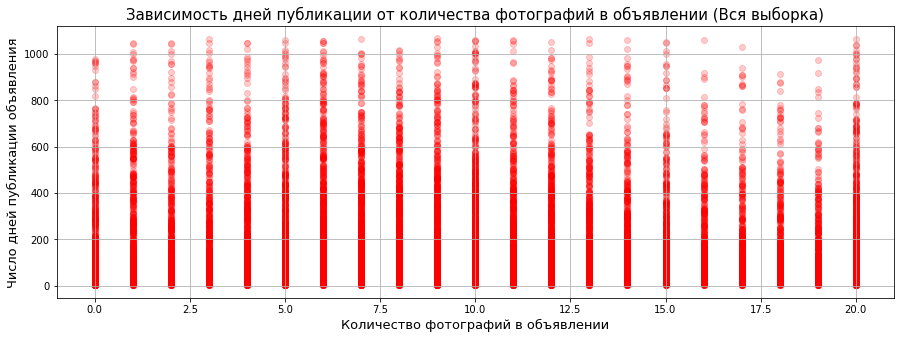

In [94]:
labels = ['Зависимость дней публикации от количества фотографий в объявлении (Вся выборка)',
          'Количество фотографий в объявлении','Число дней публикации объявления']
print_scatter(df_n, 'total_images', 'days_exposition', labels, "r",15,5)

Быстрее всего продаются квартиры с 15-19 фотографиями

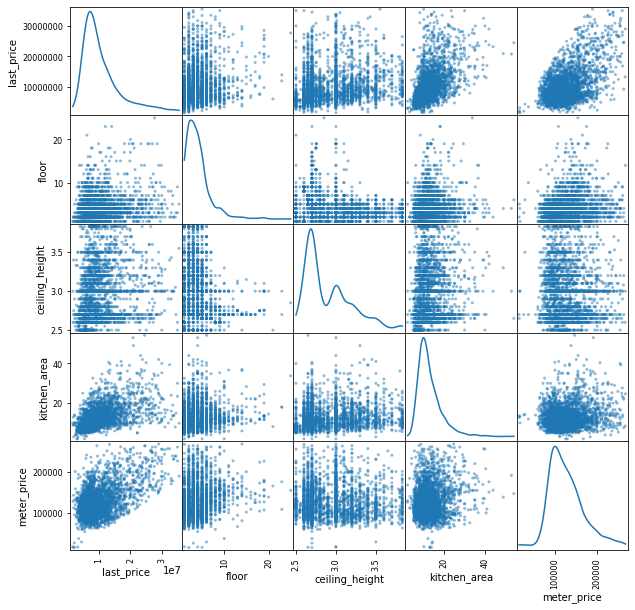

In [95]:
spb_centre.loc[spb_centre['ceiling_height']>5,'ceiling_height']= spb_centre['ceiling_height'].mean()
print_matrix(spb_centre,  
             ['last_price', 'floor', 'ceiling_height',
              'kitchen_area',
              'meter_price'
              ],10,10)

In [96]:
spb_centre[['last_price', 'floor', 'ceiling_height',
              'kitchen_area',
              'meter_price']].corr()


last_price     floor  ceiling_height  kitchen_area  \
last_price        1.000000  0.189683        0.170501      0.536388   
floor             0.189683  1.000000       -0.158442      0.133573   
ceiling_height    0.170501 -0.158442        1.000000      0.114768   
kitchen_area      0.536388  0.133573        0.114768      1.000000   
meter_price       0.540217  0.207237       -0.028096      0.180105   

                meter_price  
last_price         0.540217  
floor              0.207237  
ceiling_height    -0.028096  
kitchen_area       0.180105  
meter_price        1.000000

In [97]:
df_n[['last_price', 'floor', 'ceiling_height',
              'kitchen_area',
              'meter_price']].corr()

last_price     floor  ceiling_height  kitchen_area  \
last_price        1.000000  0.085778        0.417343      0.607965   
floor             0.085778  1.000000        0.003127      0.171090   
ceiling_height    0.417343  0.003127        1.000000      0.319571   
kitchen_area      0.607965  0.171090        0.319571      1.000000   
meter_price       0.670957  0.214696        0.301680      0.332736   

                meter_price  
last_price         0.670957  
floor              0.214696  
ceiling_height     0.301680  
kitchen_area       0.332736  
meter_price        1.000000

Явных взаимосвязей не выявлено

In [98]:
spb_centre[['balcony', 'total_area', 'ceiling_height',
              'rooms']].corr()

balcony  total_area  ceiling_height     rooms
balcony         1.000000   -0.004432       -0.096969 -0.102821
total_area     -0.004432    1.000000        0.245385  0.789317
ceiling_height -0.096969    0.245385        1.000000  0.214885
rooms          -0.102821    0.789317        0.214885  1.000000

In [99]:
df_n[['balcony', 'total_area', 'ceiling_height',
              'rooms']].corr()

balcony  total_area  ceiling_height     rooms
balcony         1.000000    0.034228       -0.035847 -0.007687
total_area      0.034228    1.000000        0.364072  0.794018
ceiling_height -0.035847    0.364072        1.000000  0.184728
rooms          -0.007687    0.794018        0.184728  1.000000

Плоащдь квартиры влияет на ее технические параметры, чтд.

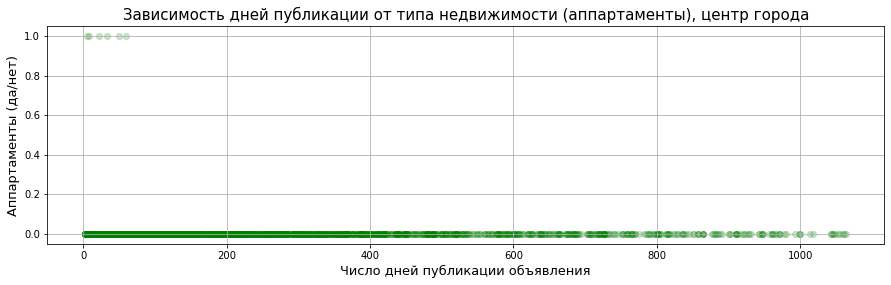

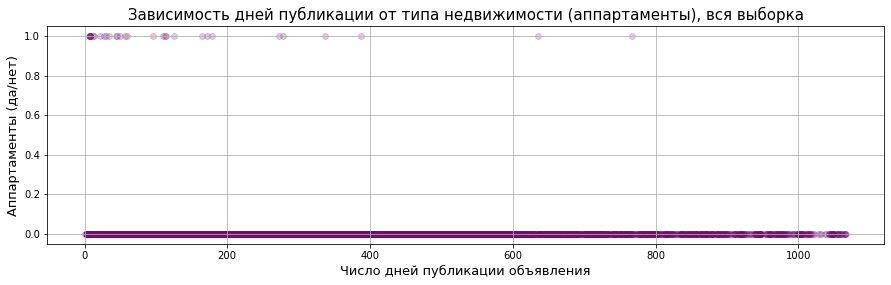

In [100]:
labels = ['Зависимость дней публикации от типа недвижимости (аппартаменты), центр города',
          'Число дней публикации объявления','Аппартаменты (да/нет)']
print_scatter(spb_centre, 'days_exposition', 'is_apartment', labels, "g", 15,4)
labels = ['Зависимость дней публикации от типа недвижимости (аппартаменты), вся выборка',
          'Число дней публикации объявления','Аппартаменты (да/нет)']
print_scatter(df_n, 'days_exposition', 'is_apartment', labels, "purple",15,4)

В основном аппартаменты продаются быстрее обычных квартир

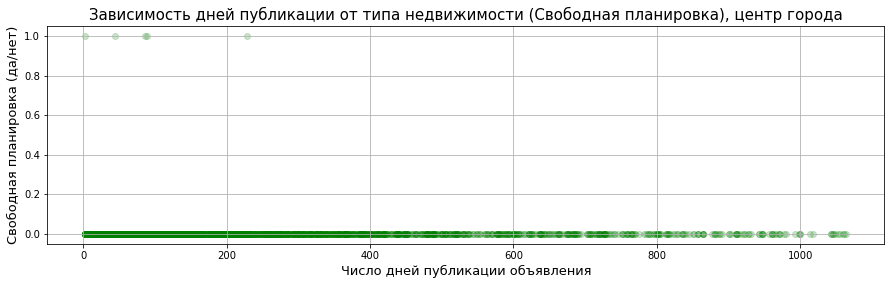

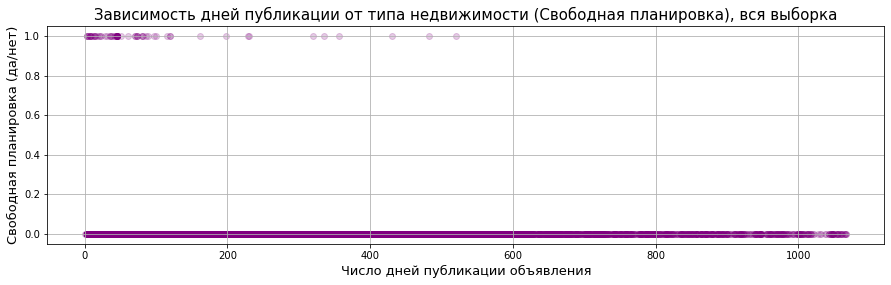

In [101]:
labels = ['Зависимость дней публикации от типа недвижимости (Свободная планировка), центр города',
          'Число дней публикации объявления','Свободная планировка (да/нет)']
print_scatter(spb_centre, 'days_exposition', 'open_plan', labels, "g", 15,4)
labels = ['Зависимость дней публикации от типа недвижимости (Свободная планировка), вся выборка',
          'Число дней публикации объявления','Свободная планировка (да/нет)']
print_scatter(df_n, 'days_exposition', 'open_plan', labels, "purple",15,4)

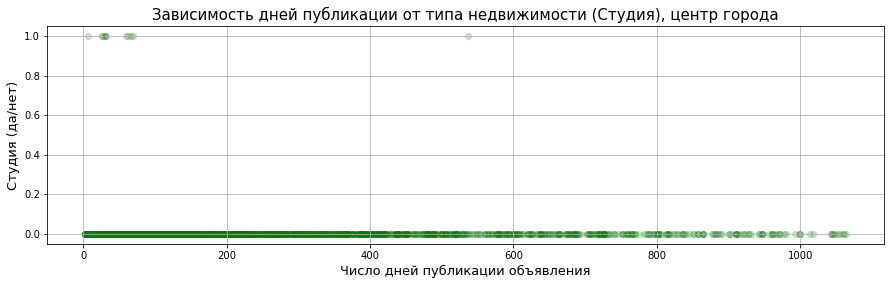

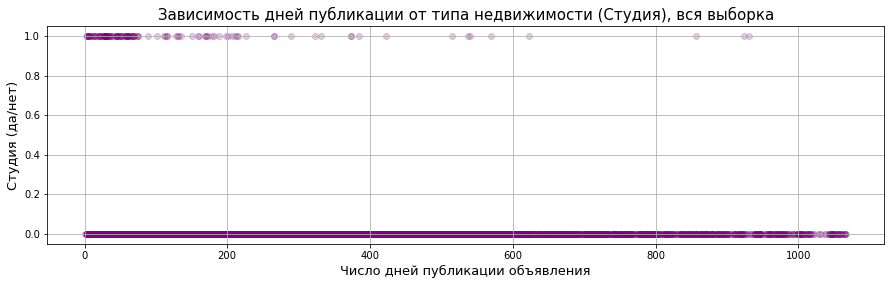

In [102]:
labels = ['Зависимость дней публикации от типа недвижимости (Студия), центр города',
          'Число дней публикации объявления','Студия (да/нет)']
print_scatter(spb_centre, 'days_exposition', 'studio', labels, "g", 15,4)
labels = ['Зависимость дней публикации от типа недвижимости (Студия), вся выборка',
          'Число дней публикации объявления','Студия (да/нет)']
print_scatter(df_n, 'days_exposition', 'studio', labels, "purple",15,4)

В целом для квартир студий и квартир с свободной планировкой можно сделать такой же вывод, как и для аппартаментов - они продаются в разы быстрее обычной недвижимости, скорее всего это связано с низкой стоимостью такого рода квартир

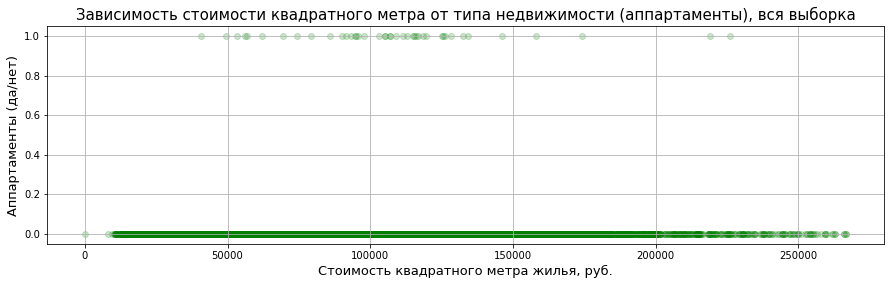

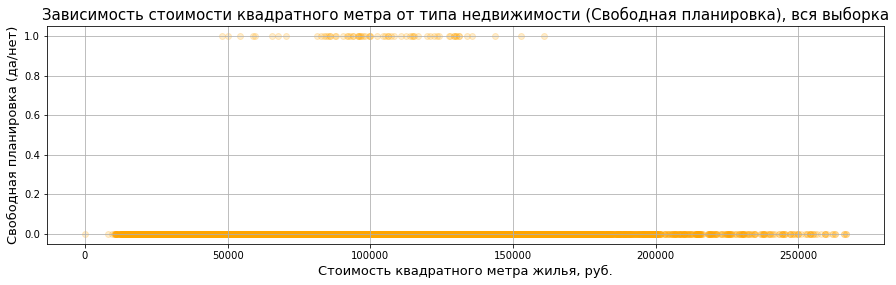

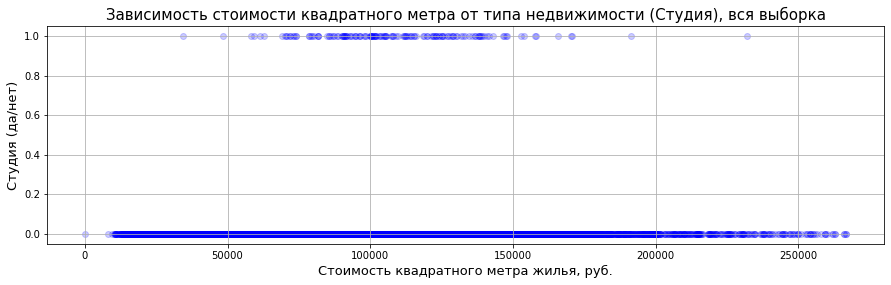

In [103]:
labels = ['Зависимость стоимости квадратного метра от типа недвижимости (аппартаменты), вся выборка',
          'Стоимость квадратного метра жилья, руб.','Аппартаменты (да/нет)']
print_scatter(df_n, 'meter_price', 'is_apartment', labels, "g", 15,4)
labels = ['Зависимость стоимости квадратного метра от типа недвижимости (Свободная планировка), вся выборка',
          'Стоимость квадратного метра жилья, руб.','Свободная планировка (да/нет)']
print_scatter(df_n, 'meter_price', 'open_plan', labels, "orange", 15,4)
labels = ['Зависимость стоимости квадратного метра от типа недвижимости (Студия), вся выборка',
          'Стоимость квадратного метра жилья, руб.','Студия (да/нет)']
print_scatter(df_n, 'meter_price', 'studio', labels, "b", 15,4)

Отчетливо видно, что квартиры из категорй "студия", "аппартаменты" и "свободная планировка" находяттся в одном и том же ценовом диапазоне. 

Динамика продаж данных квартир так же совпадает

Перейдем к географическим метрикам, рассмотрим взаимосвязь стоимости квартиры и скорости ее продажи от дальности до центра/аэропорта/парка/водоема на общей выборке данных, так как в центре города эти данные не будут сильно влиять на стоимость квартиры

In [104]:
df_n[['meter_price','airports_nearest', 'parks_nearest', 'ponds_nearest','cityCenters_nearest','days_exposition']].corr()


meter_price  airports_nearest  parks_nearest  \
meter_price             1.000000         -0.084527       0.069601   
airports_nearest       -0.084527          1.000000      -0.050605   
parks_nearest           0.069601         -0.050605       1.000000   
ponds_nearest          -0.007282         -0.106347      -0.001861   
cityCenters_nearest    -0.411592          0.305584      -0.047143   
days_exposition         0.008544         -0.023810       0.002399   

                     ponds_nearest  cityCenters_nearest  days_exposition  
meter_price              -0.007282            -0.411592         0.008544  
airports_nearest         -0.106347             0.305584        -0.023810  
parks_nearest            -0.001861            -0.047143         0.002399  
ponds_nearest             1.000000            -0.053987        -0.041773  
cityCenters_nearest      -0.053987             1.000000        -0.050860  
days_exposition          -0.041773            -0.050860         1.000000

In [105]:
df_n[['meter_price','parks_around3000', 'ponds_around3000', 'days_exposition']].corr()

meter_price  parks_around3000  ponds_around3000  \
meter_price          1.000000          0.293894          0.305717   
parks_around3000     0.293894          1.000000          0.382535   
ponds_around3000     0.305717          0.382535          1.000000   
days_exposition      0.008544          0.040888          0.047489   

                  days_exposition  
meter_price              0.008544  
parks_around3000         0.040888  
ponds_around3000         0.047489  
days_exposition          1.000000

Есть очень слабая корреляция между количеством парков и прудов в радиусе 3км и стоимостью квадратного метра жилья (коэффициент корреляции ~ 0.3)

А так же очевидная слабая отрицательная корреляция между отдаленносттью от центра города и стоимостью квадратного метра (чем дальше от центра - тем меньше цена)

И еще одна очевидная взаимосвязь - расстояние до аэропортта и расстояние до центра города (коэффициент корреляции ~ 0.3)

Проверим зависимость стоимости квадратного метра от процентного соотношения площади кухни и жилой площади к общей площади квартиры:

In [106]:
df_n[['meter_price','living_to_total', 'kitchen_to_total', 'days_exposition']].corr()

meter_price  living_to_total  kitchen_to_total  \
meter_price          1.000000        -0.210237          0.211718   
living_to_total     -0.210237         1.000000         -0.453470   
kitchen_to_total     0.211718        -0.453470          1.000000   
days_exposition      0.008544        -0.001304         -0.056718   

                  days_exposition  
meter_price              0.008544  
living_to_total         -0.001304  
kitchen_to_total        -0.056718  
days_exposition          1.000000

In [107]:
spb_centre[['meter_price','living_to_total', 'kitchen_to_total', 'days_exposition']].corr()

meter_price  living_to_total  kitchen_to_total  \
meter_price          1.000000        -0.246245          0.289554   
living_to_total     -0.246245         1.000000         -0.340330   
kitchen_to_total     0.289554        -0.340330          1.000000   
days_exposition     -0.008967        -0.041045         -0.034281   

                  days_exposition  
meter_price             -0.008967  
living_to_total         -0.041045  
kitchen_to_total        -0.034281  
days_exposition          1.000000

Соотношение площади кухни к общей площади квартиры немного влияет на цену недвижимости

* По сравнению с общими данными по городу и области в центра города более ярко выражена разница между стоимостью квартир на 1 этаже и на других
* Медианное время нахождения объявления на сайте увеличилось почти на 40 дней, скорее всего это связанно с увеличением стоимости квартир в центре города по сравнению с окраиной
* Из матрицы диаграм рассеяния заметна более явная меньшая зашумленность данных, при переходе от общей выборке к центру города
* Чем дороже рподаваемая недвижимость, тем больше фотографий выкладиывает продавец
* Так же скорость продажи квартиры зависит от количества фотографий, чем больше - тем лучше

## Общий вывод

Исходя из проведенного исследования мы можем сделать следующие выводы:

* Заметная корреляция между стоимостью квадратного метра жилья и другими параметрами есть только у параметров, описывающих характеристики жилья;
* Заметной корреляции между днем подачи объявления и стоимостью жилья - нет;

In [108]:
df_n1.corr()

last_price  meter_price  total_area     rooms  \
last_price             1.000000     0.670957    0.800313  0.508917   
meter_price            0.670957     1.000000    0.166187 -0.063280   
total_area             0.800313     0.166187    1.000000  0.794018   
rooms                  0.508917    -0.063280    0.794018  1.000000   
cityCenters_nearest   -0.356028    -0.411592   -0.237028 -0.173511   
day_of_week_exp       -0.015161    -0.011787   -0.013321 -0.004088   
mounth_of_exp         -0.000264    -0.005648    0.003868 -0.006191   
year_of_exp           -0.019165     0.056951   -0.066363 -0.039437   

                     cityCenters_nearest  day_of_week_exp  mounth_of_exp  \
last_price                     -0.356028        -0.015161      -0.000264   
meter_price                    -0.411592        -0.011787      -0.005648   
total_area                     -0.237028        -0.013321       0.003868   
rooms                          -0.173511        -0.004088      -0.006191   
cityCenters_nearest             1.000000         0.004873      -0.007131   
day_of_week_exp                 0.004873         1.000000       0.010390   
mounth_of_exp                  -0.007131         0.010390       1.000000   
year_of_exp                     0.025078        -0.006791      -0.274675   

                     year_of_exp  
last_price             -0.019165  
meter_price             0.056951  
total_area             -0.066363  
rooms                  -0.039437  
cityCenters_nearest     0.025078  
day_of_week_exp        -0.006791  
mounth_of_exp          -0.274675  
year_of_exp             1.000000

* Данные объявлений в центре города менее зашумленны, чем общие данные по городу и области, зависимости лучше заметны;

Матрица диаграмм рассеяния для общей выбоки данных


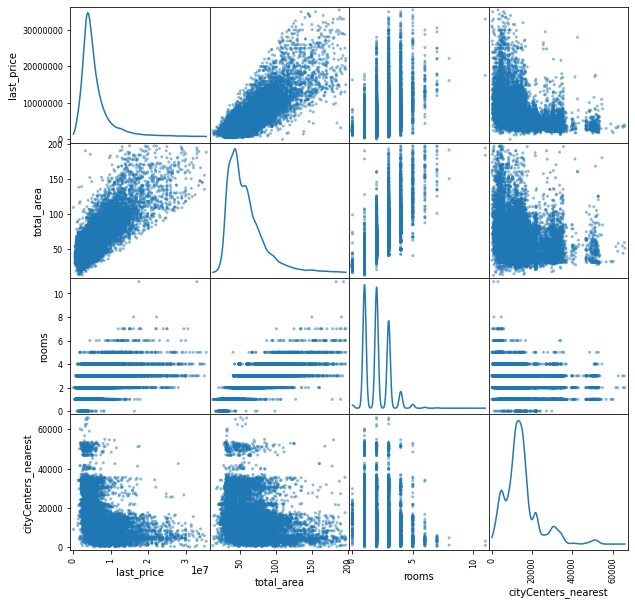

In [109]:
print('Матрица диаграмм рассеяния для общей выбоки данных')
print_matrix(df_n,  
             ['last_price','total_area', 
              'rooms',
              'cityCenters_nearest',
              ],10,10)


Матрица диаграмм рассеяния для ценра Санкт-Петербурга


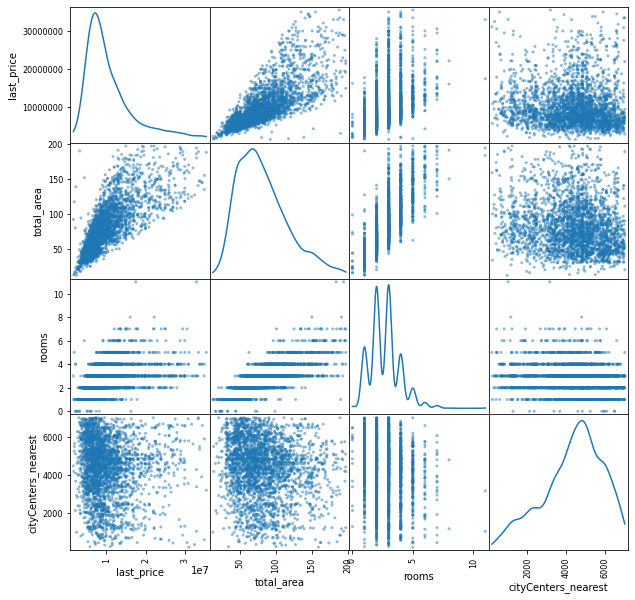

In [110]:
print('Матрица диаграмм рассеяния для ценра Санкт-Петербурга')

print_matrix(spb_centre,  
             ['last_price','total_area', 
              'rooms',
              'cityCenters_nearest',
              ],10,10)


* Корреляции между временем продажи жилья и его стоимостью не выявлено

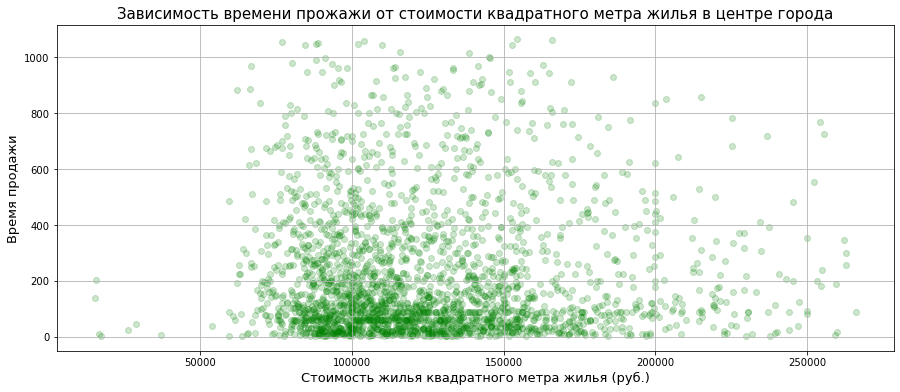

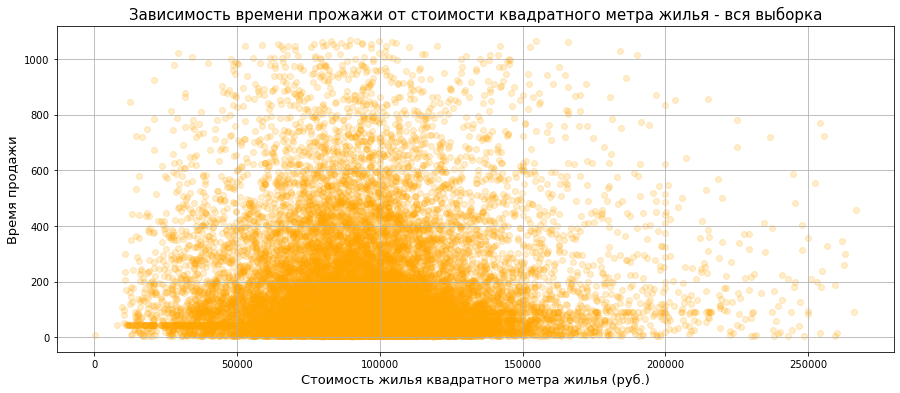

meter_price  days_exposition
meter_price         1.000000         0.008544
days_exposition     0.008544         1.000000

In [111]:
labels = ['Зависимость времени прожажи от стоимости квадратного метра жилья в центре города',
          'Стоимость жилья квадратного метра жилья (руб.)','Время продажи']
print_scatter(spb_centre, 'meter_price', 'days_exposition', labels,'g', 15,6)
labels = ['Зависимость времени прожажи от стоимости квадратного метра жилья - вся выборка',
          'Стоимость жилья квадратного метра жилья (руб.)','Время продажи']
print_scatter(df_n, 'meter_price', 'days_exposition', labels,'orange', 15,6)
df_n[['meter_price', 'days_exposition']].corr()

* Чем более подробное объявление (количество фото), тем быстрее продается недвижимость;


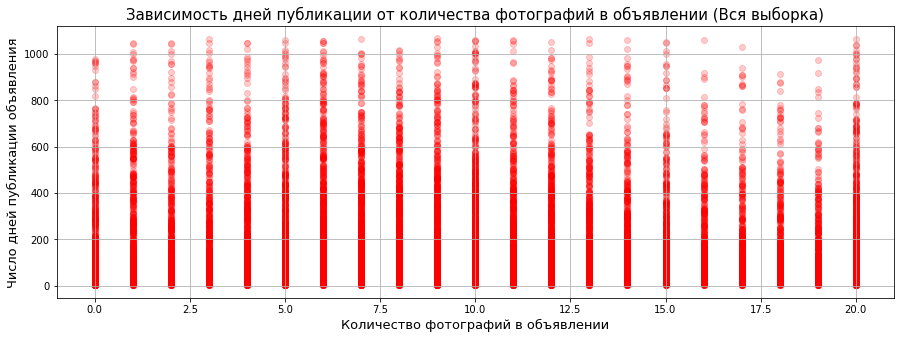

In [112]:
labels = ['Зависимость дней публикации от количества фотографий в объявлении (Вся выборка)',
          'Количество фотографий в объявлении','Число дней публикации объявления']
print_scatter(df_n, 'total_images', 'days_exposition', labels, "r",15,5)

* Люди покупают аппартаменты так же охотно, как квартиры студии и квартиры с свободной планировкой (скорее всего дело в схожей цене, людей в данной ценовой категории не сильно смущает, что аппартаменты не считаются жилими помещениями);

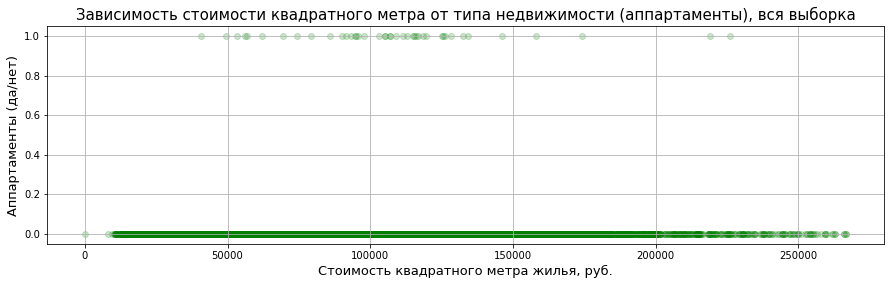

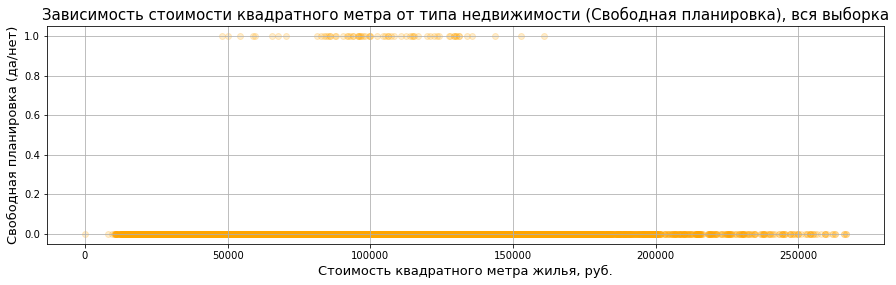

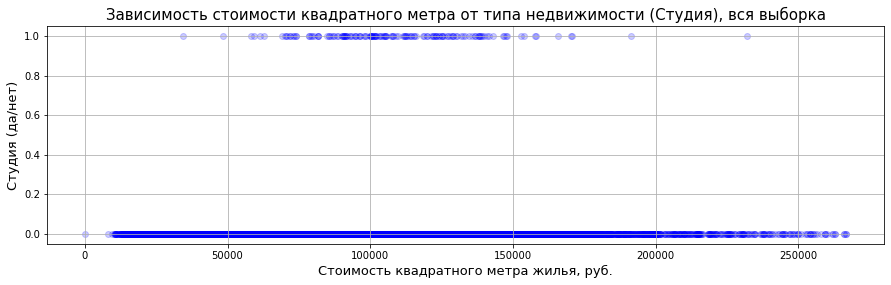

In [113]:
labels = ['Зависимость стоимости квадратного метра от типа недвижимости (аппартаменты), вся выборка',
          'Стоимость квадратного метра жилья, руб.','Аппартаменты (да/нет)']
print_scatter(df_n, 'meter_price', 'is_apartment', labels, "g", 15,4)
labels = ['Зависимость стоимости квадратного метра от типа недвижимости (Свободная планировка), вся выборка',
          'Стоимость квадратного метра жилья, руб.','Свободная планировка (да/нет)']
print_scatter(df_n, 'meter_price', 'open_plan', labels, "orange", 15,4)
labels = ['Зависимость стоимости квадратного метра от типа недвижимости (Студия), вся выборка',
          'Стоимость квадратного метра жилья, руб.','Студия (да/нет)']
print_scatter(df_n, 'meter_price', 'studio', labels, "b", 15,4)

* Есть очень слабая зовисимость стоимости квадратного метра жилья от наличия парков или водоемов в радиусе 3 км;

In [114]:
df_n[['meter_price','parks_around3000', 'ponds_around3000', 'days_exposition']].corr()

meter_price  parks_around3000  ponds_around3000  \
meter_price          1.000000          0.293894          0.305717   
parks_around3000     0.293894          1.000000          0.382535   
ponds_around3000     0.305717          0.382535          1.000000   
days_exposition      0.008544          0.040888          0.047489   

                  days_exposition  
meter_price              0.008544  
parks_around3000         0.040888  
ponds_around3000         0.047489  
days_exposition          1.000000

* Время продажи жилья в центре Санкт-Питербурга больше, чем время продажи по общей выборке

Гистограмма распределения времени продажи по общей выборке:


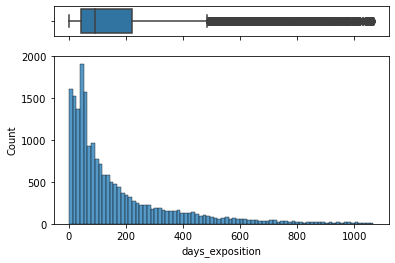

Гистограмма распределения времени продажи по центру города:


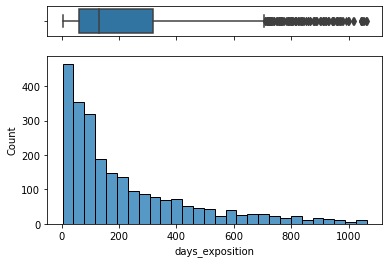

Быстрая продажа по общей выборке: 45.0 дней
Быстрая продажа по центру города: 60.0 дней

Медианная продажа по общей выборке: 95.0 дней
Медианная продажа по центру города: 131.0 дней

Долгая продажа по общей выборке: 232.0 дней
Долгая продажа по центру города: 319.0 дней

Медианное время продажи квартиры в центре города больше на 37%, чем медианное время продажи квартиры по общей выборке


In [115]:
print(f"Гистограмма распределения времени продажи по общей выборке:")
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
sns.boxplot(data=df_n, x="days_exposition", ax=ax_box)
sns.histplot(data=df_n, x="days_exposition", ax=ax_hist)
ax_box.set(xlabel='')
plt.show()
print(f"Гистограмма распределения времени продажи по центру города:")

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
sns.boxplot(data=spb_centre, x="days_exposition", ax=ax_box)
sns.histplot(data=spb_centre, x="days_exposition", ax=ax_hist)
ax_box.set(xlabel='')
plt.show()

print(f"Быстрая продажа по общей выборке: {round(df['days_exposition'].quantile(.25),1)} дней")
print(f"Быстрая продажа по центру города: {round(spb_centre['days_exposition'].quantile(.25),1)} дней\n")

print(f"Медианная продажа по общей выборке: {round(df['days_exposition'].quantile(.50),1)} дней")
print(f"Медианная продажа по центру города: {round(spb_centre['days_exposition'].quantile(.50),1)} дней\n")

print(f"Долгая продажа по общей выборке: {round(df['days_exposition'].quantile(.75),1)} дней")
print(f"Долгая продажа по центру города: {round(spb_centre['days_exposition'].quantile(.75),1)} дней\n")
persents_median = int(((spb_centre['days_exposition'].quantile(.50)/df['days_exposition'].quantile(.50))-1)*100)

print(f"Медианное время продажи квартиры в центре города больше на {persents_median}%, чем медианное время продажи квартиры по общей выборке")
